# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

#### Общий анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy.matlib as np
import csv
import requests
import seaborn as sns
import math
from urllib.parse import urlencode 
 

In [2]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

#Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', 20)
 
# Сброс ограничений на количество символов в записи
#pd.set_option('display.max_colwidth', None)
# Отключение settingwithcopywarning
pd.options.mode.chained_assignment = None
#Формат float
pd.options.display.float_format = '{:,.2f}'.format
# Увеличение окна вывода функций
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 40em; }</style>"))

Поиск символа-разделителя в csv

In [3]:
def find_delimiter(path):
    sniffer = csv.Sniffer()
    with open(path) as fp:
        delimiter = sniffer.sniff(fp.read(5000)).delimiter
    return delimiter

In [4]:
dlm = find_delimiter('/datasets/real_estate_data.csv')
dlm

'\t'

In [5]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = dlm)      #delim_whitespace=True
data.head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00
5,10,"2,890,000.00",30.40,2018-09-10T00:00:00,1,NaN,12.00,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.00
6,6,"3,700,000.00",37.30,2017-11-02T00:00:00,1,NaN,26.00,10.60,6,NaN,False,False,14.40,1.00,посёлок Парголово,"52,996.00","19,143.00",0.00,NaN,0.00,NaN,155.00
7,5,"7,915,000.00",71.60,2019-04-18T00:00:00,2,NaN,24.00,NaN,22,NaN,False,False,18.90,2.00,Санкт-Петербург,"23,982.00","11,634.00",0.00,NaN,0.00,NaN,NaN
8,20,"2,900,000.00",33.16,2018-05-23T00:00:00,1,NaN,27.00,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.00
9,18,"5,400,000.00",61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,NaN,False,False,6.50,2.00,Санкт-Петербург,"50,898.00","15,008.00",0.00,NaN,0.00,NaN,289.00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

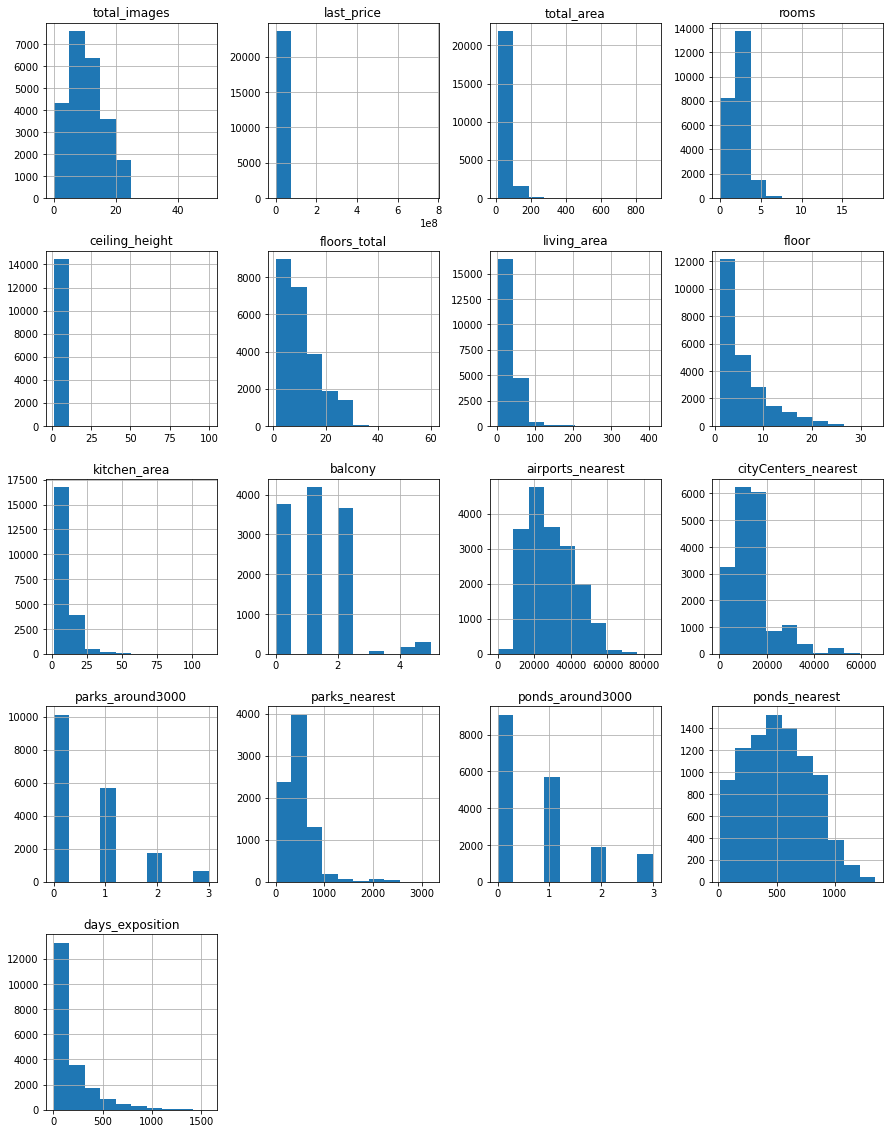

In [7]:
data.hist(figsize=(15, 20));

In [8]:
data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.00,0.10,0.12,0.10,-0.00,0.01,0.10,0.03,-0.03,-0.02,0.10,0.12,-0.00,-0.05,0.02,-0.01,-0.01,-0.00,-0.03
last_price,0.10,1.00,0.65,0.36,0.09,-0.01,0.57,0.03,-0.03,-0.01,0.52,0.03,-0.03,-0.21,0.15,-0.02,0.16,-0.08,0.08
total_area,0.12,0.65,1.00,0.76,0.10,-0.08,0.94,-0.02,-0.07,-0.03,0.61,0.05,-0.03,-0.23,0.16,-0.02,0.16,-0.10,0.15
rooms,0.10,0.36,0.76,1.00,0.05,-0.23,0.85,-0.15,-0.15,-0.09,0.27,0.02,-0.06,-0.18,0.14,-0.05,0.09,-0.06,0.13
ceiling_height,-0.00,0.09,0.10,0.05,1.00,-0.03,0.09,-0.01,0.00,0.04,0.09,0.04,-0.02,-0.09,0.07,-0.02,0.08,-0.06,0.02
floors_total,0.01,-0.01,-0.08,-0.23,-0.03,1.00,-0.17,0.68,0.07,0.05,0.16,0.19,0.11,0.02,-0.25,0.10,-0.12,0.04,-0.05
living_area,0.10,0.57,0.94,0.85,0.09,-0.17,1.00,-0.10,-0.06,-0.03,0.43,0.02,-0.06,-0.23,0.18,-0.05,0.15,-0.08,0.14
floor,0.03,0.03,-0.02,-0.15,-0.01,0.68,-0.10,1.00,0.04,0.04,0.14,0.17,0.07,0.01,-0.16,0.07,-0.08,0.02,-0.04
studio,-0.03,-0.03,-0.07,-0.15,0.00,0.07,-0.06,0.04,1.00,-0.00,NaN,0.03,-0.02,-0.01,-0.03,0.01,0.00,0.00,-0.02
open_plan,-0.02,-0.01,-0.03,-0.09,0.04,0.05,-0.03,0.04,-0.00,1.00,NaN,0.02,-0.01,-0.00,-0.01,0.01,0.01,-0.00,-0.02


#### Первичный анализ:
Количество записей: 23699 <br />
Есть корреляция между ценой и (в порядке убывания) площадью, жилой площадью, площадью кухни, количеством комнат и этажем

Функция выдачи информации о характеристиках объекта:

In [9]:
def informator(param,plot_hist = True):
    print('Описание данных:')
    print(param.describe(datetime_is_numeric=True))
    typer = type(param[0])
    print('\nТип:', typer)
    if plot_hist and not 'str' in str(typer):
        print('\nГистограмма значений:')
        param.hist();

##### **airports_nearest** — расстояние до ближайшего аэропорта в метрах (м) #####

Описание данных:
count   18,157.00
mean    28,793.67
std     12,630.88
min          0.00
25%     18,585.00
50%     26,726.00
75%     37,273.00
max     84,869.00
Name: airports_nearest, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


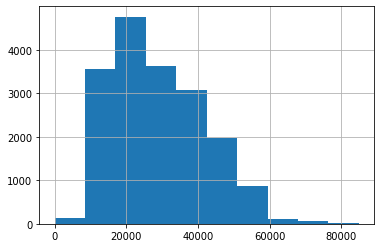

In [10]:
informator(data['airports_nearest'])

Странно, эти данные заявлены как автоматически добавленные<br />
Возможно, пустые данные - если аэропорт очень далеко (более 80 км)

##### **balcony** — число балконов

Описание данных:
count   12,180.00
mean         1.15
std          1.07
min          0.00
25%          0.00
50%          1.00
75%          2.00
max          5.00
Name: balcony, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


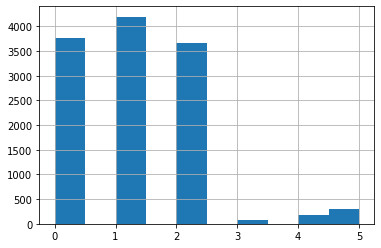

In [11]:
informator(data['balcony'])

Возможно, отсутствующие данные в квартирах без балконов. <br />
Тип: float64, должен быть int

##### **ceiling_height** — высота потолков (м) 

Описание данных:
count   14,504.00
mean         2.77
std          1.26
min          1.00
25%          2.52
50%          2.65
75%          2.80
max        100.00
Name: ceiling_height, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


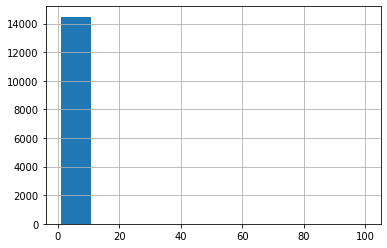

In [12]:
informator(data['ceiling_height'])

Есть аномальные значения как в минимуме, так и в максимуме

##### **cityCenters_nearest** — расстояние до центра города (м) #####


Описание данных:
count   18,180.00
mean    14,191.28
std      8,608.39
min        181.00
25%      9,238.00
50%     13,098.50
75%     16,293.00
max     65,968.00
Name: cityCenters_nearest, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


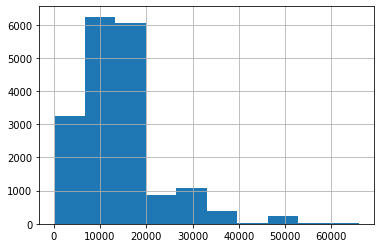

In [13]:
informator(data['cityCenters_nearest'])

Странно, эти данные заявлены как автоматически добавленные<br />
Есть пик в районе 50 км - возможно, крупный райцентр

##### **days_exposition** — сколько дней было размещено объявление (от публикации до снятия) #####

Описание данных:
count   20,518.00
mean       180.89
std        219.73
min          1.00
25%         45.00
50%         95.00
75%        232.00
max      1,580.00
Name: days_exposition, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


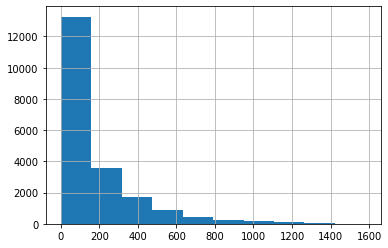

In [14]:
informator(data['days_exposition'])

Возможно, нет данных по еще не закрытым объявлениям - тогда надо выяснить дату формирования выборки

##### **first_day_exposition — дата публикации**
Количество записей:23699/23699 <br />

In [15]:
informator(data['first_day_exposition'])

Описание данных:
count                   23699
unique                   1491
top       2018-02-01T00:00:00
freq                      368
Name: first_day_exposition, dtype: object

Тип: <class 'str'>


тип: str (должен быть datatime) - требуется преобразовать

#####  **floor** — этаж

Описание данных:
count   23,699.00
mean         5.89
std          4.89
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         33.00
Name: floor, dtype: float64

Тип: <class 'numpy.int64'>

Гистограмма значений:


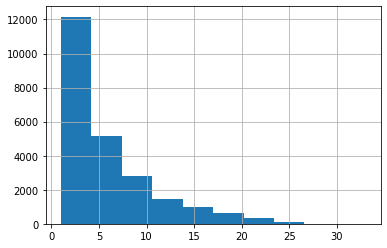

In [16]:
informator(data['floor'])

In [17]:
data['floor'].unique()

array([ 8,  1,  4,  9, 13,  5,  6, 22, 26,  7,  3,  2, 11, 15, 18, 10, 19,
       16, 20, 27, 25, 17, 14, 12, 21, 28, 24, 23, 30, 29, 32, 33, 31])

Нет паразитных значений

#####  **floors_total**— всего этажей в доме

Описание данных:
count   23,613.00
mean        10.67
std          6.60
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


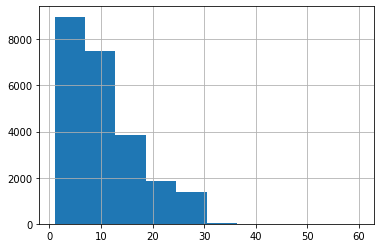

In [18]:
informator(data['floors_total'])

#####  **is_apartment** — апартаменты (булев тип)

In [19]:
informator(data['is_apartment'], False)

Описание данных:
count      2775
unique        2
top       False
freq       2725
Name: is_apartment, dtype: object

Тип: <class 'float'>


In [20]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Тип: float (должен быть bool) <br />
Скорее всего, незаполненные - не аппартаменты<br />

##### **kitchen_area** — площадь кухни в квадратных метрах (м²)

Описание данных:
count   21,421.00
mean        10.57
std          5.91
min          1.30
25%          7.00
50%          9.10
75%         12.00
max        112.00
Name: kitchen_area, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


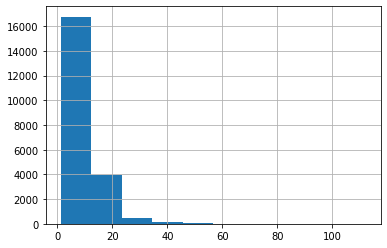

In [21]:
informator(data['kitchen_area'])

1. Возможно, в студиях нет выделенных кухонь<br />
2. Есть слишком большие значения

##### **last_price** — цена на момент снятия с публикации
Количество записей:23669/23699
Тип: float64

Описание данных:
count        23,699.00
mean      6,541,548.77
std      10,887,013.27
min          12,190.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,800,000.00
max     763,000,000.00
Name: last_price, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


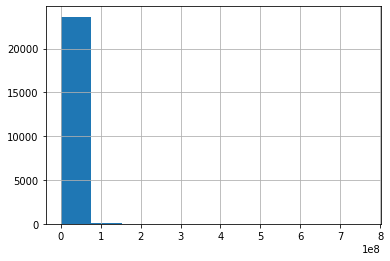

In [22]:
informator(data['last_price'])

Подозрительная минимальная цена: 12900 руб

##### **living_area** — жилая площадь в квадратных метрах (м²)

Описание данных:
count   21,796.00
mean        34.46
std         22.03
min          2.00
25%         18.60
50%         30.00
75%         42.30
max        409.70
Name: living_area, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


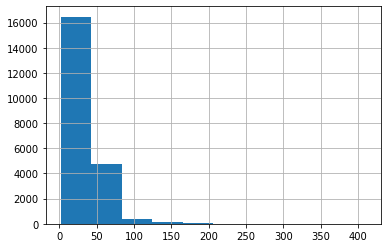

In [23]:
informator(data['living_area'])

Требуется проанализировать, где нет данных

##### **locality_name** — название населённого пункта

In [24]:
informator(data['locality_name'])

Описание данных:
count               23650
unique                364
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object

Тип: <class 'str'>


1. Нет части названий
2. Требуется чистка дубликатов

#####  **open_plan** — свободная планировка (булев тип)

In [25]:
informator(data['open_plan'], False)

Описание данных:
count     23699
unique        2
top       False
freq      23632
Name: open_plan, dtype: object

Тип: <class 'numpy.bool_'>


In [26]:
data['open_plan'].unique()

array([False,  True])

#####  **parks_around3000** — число парков в радиусе 3 км

Описание данных:
count   18,181.00
mean         0.61
std          0.80
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          3.00
Name: parks_around3000, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


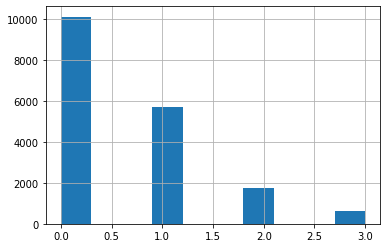

In [27]:
informator(data['parks_around3000'])

1. Тип: float64 (должно быть int64)
2. Видимо, пустые значения - 0

#####  **parks_nearest** — расстояние до ближайшего парка (м)

Описание данных:
count   8,079.00
mean      490.80
std       342.32
min         1.00
25%       288.00
50%       455.00
75%       612.00
max     3,190.00
Name: parks_nearest, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


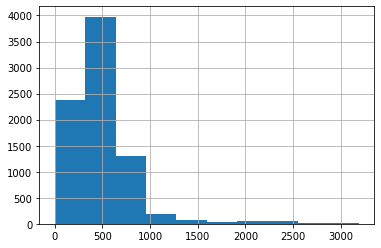

In [28]:
informator(data['parks_nearest'])

Странно, в 2,5 раза меньше, чем записей с парками. Надо посмотреть parks_around3000 на ненулевые значения

#####  **ponds_around3000** — число водоёмов в радиусе 3 км

Описание данных:
count   18,181.00
mean         0.77
std          0.94
min          0.00
25%          0.00
50%          1.00
75%          1.00
max          3.00
Name: ponds_around3000, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


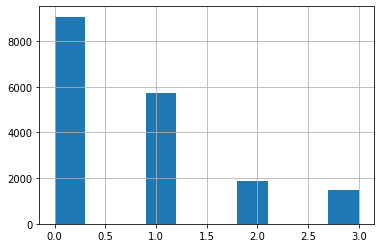

In [29]:
informator(data['ponds_around3000'])

1. Тип: float64 (должно быть int64)
2. Видимо, пустые значения - 0
3. Совпадает с парками

#####  **ponds_nearest** — расстояние до ближайшего водоёма (м)

Описание данных:
count   9,110.00
mean      517.98
std       277.72
min        13.00
25%       294.00
50%       502.00
75%       729.00
max     1,344.00
Name: ponds_nearest, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


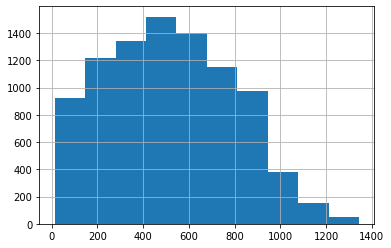

In [30]:
informator(data['ponds_nearest'])

Странно, в 2 раза меньше, чем записей с водоёмами. Надо посмотреть ponds_around3000 на ненулевые значения

#####  **rooms** — число комнат

Описание данных:
count   23,699.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

Тип: <class 'numpy.int64'>

Гистограмма значений:


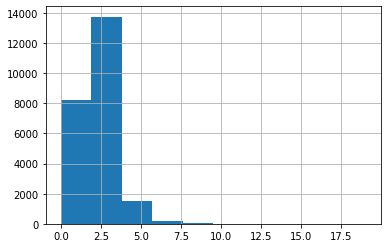

In [31]:
informator(data['rooms'])

Нулевое значение некорректно

#####  **studio** — квартира-студия (булев тип)

In [32]:
informator(data['studio'], False)

Описание данных:
count     23699
unique        2
top       False
freq      23550
Name: studio, dtype: object

Тип: <class 'numpy.bool_'>


##### **total_area** — общая площадь квартиры в квадратных метрах (м²)

Описание данных:
count   23,699.00
mean        60.35
std         35.65
min         12.00
25%         40.00
50%         52.00
75%         69.90
max        900.00
Name: total_area, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


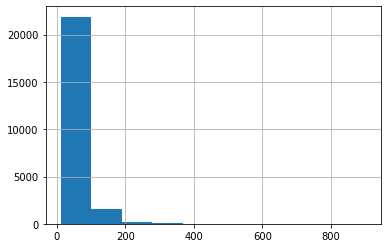

In [33]:
informator(data['total_area'])

Обратить внимание на большие площади

#####  **total_images** — число фотографий квартиры в объявлении
Количество записей:23699/23699 <br />
Тип: int64

Описание данных:
count   23,699.00
mean         9.86
std          5.68
min          0.00
25%          6.00
50%          9.00
75%         14.00
max         50.00
Name: total_images, dtype: float64

Тип: <class 'numpy.int64'>

Гистограмма значений:


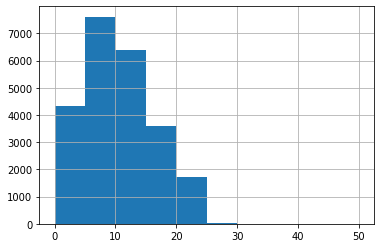

In [34]:
informator(data['total_images'])

#### Общий вывод по этапу 1

1. В предоставленных данных находится информация о 23699 квартирах в Санкт-Петербурге и Ленинградской области.
2. Состояние данных - неудовлетварительное, отсутствуют даже те данные, которые Яндекс.Недвижимость должна была добавлять автоматически. 
3. Много пропущенных, некорректных данных. 
3. Почти все данные требуют предобработки :(

### Предобработка данных

#### **Расположение**

##### **locality_name** — название населённого пункта

In [35]:
informator(data['locality_name'])

Описание данных:
count               23650
unique                364
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object

Тип: <class 'str'>


1. Нет части названий
2. Требуется чистка дубликатов

###### Анализ названий населеных пунктов

In [36]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [37]:
len(data['locality_name'].unique())

365

###### Удаление данных с неизвестным н.п. расположения

In [38]:
data['locality_name'].isna().sum()

49

In [39]:
data = data.dropna(subset=['locality_name'])

###### Замена в слове "поселок"  е на ё

In [40]:
def e_replace(str):
    str = str.replace('поселок','посёлок')
    return str

In [41]:
data['locality_name'] = data['locality_name'].apply(e_replace)
len(data['locality_name'].unique())

330

###### Разделение поля 'locality_name' на тип и название

In [42]:
def city_ceparite_row(row):
    str=row['locality_name']
    #print(str)
    # Выделение типа
    types = ['городской посёлок','деревня','посёлок городского типа', 'посёлок станции', 'посёлок при железнодорожной станции',
             'садоводческое некоммерческое товарищество', 'садовое товарищество','коттеджный посёлок', 
             'посёлок', 'село'] # "посёлок" специально в конце, чтобы не перебивать предшествующие значения
    type = ''
    for type in types:
        if type in str:
            break
        else: 
            type = ''
    #Выделение имени
    if type != '':
        name = str[len(type)+1:]
    else:
        name = str
        type = 'город' #Проверил, что все н.п., у которых не указан тип, являются городами
    if name == 'Русско': # Найденный вручную сбой данных
        name = 'Русско-Высоцкое'
        type = 'село'
    row['city_name'] = name
    row['city_type'] = type
    return row

In [43]:
data = data.apply(city_ceparite_row, axis=1)
data[data['city_type']=='']['city_name'].unique()

array([], dtype=object)

In [44]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,Санкт-Петербург,город
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,Шушары,посёлок
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,Санкт-Петербург,город
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,Санкт-Петербург,город
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,Санкт-Петербург,город


###### Удаление неявных дубликатов в типах н.п.

In [45]:
replace_types = {'городской посёлок':'посёлок городского типа',
                          'посёлок станции':'посёлок при железнодорожной станции',
                          'садоводческое некоммерческое товарищество':'садовое товарищество'}
data = data.replace({'city_type':replace_types})

In [46]:
data['city_type'].unique()

array(['город', 'посёлок', 'посёлок городского типа', 'деревня',
       'садовое товарищество', 'село',
       'посёлок при железнодорожной станции', 'коттеджный посёлок'],
      dtype=object)

In [47]:
data[data['city_type'] == 'коттеджный посёлок']

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type
12821,15,"4,650,000.00",72.00,2017-11-22T00:00:00,1,3.00,2.00,52.00,2,False,False,False,NaN,1.00,коттеджный посёлок Счастье,NaN,NaN,NaN,NaN,NaN,NaN,7.00,Счастье,коттеджный посёлок
16611,2,"2,000,000.00",55.00,2017-06-29T00:00:00,1,2.70,2.00,24.00,2,NaN,False,False,18.00,0.00,коттеджный посёлок Кивеннапа Север,NaN,NaN,NaN,NaN,NaN,NaN,45.00,Кивеннапа Север,коттеджный посёлок
23048,7,"2,449,000.00",53.60,2018-07-10T00:00:00,2,NaN,5.00,28.40,2,NaN,False,False,8.80,NaN,коттеджный посёлок Лесное,NaN,NaN,NaN,NaN,NaN,NaN,161.00,Лесное,коттеджный посёлок


###### Приведение к одному типу объявлений из одного н.п.
У некоторых населенных пунктов может быть указан разный тип данных в разных объявлениях

In [48]:
many_types = {}
for city in data['city_name'].unique():
    type_city =data.query('city_name==@city').groupby(by='city_type')
    counter = len(type_city)
    if counter > 1:
        many_types[city] = counter
        print(city,'-', counter,':', data.query('city_name==@city')['city_type'].unique())

Мурино - 2 : ['посёлок' 'город']
Кудрово - 2 : ['деревня' 'город']
Фёдоровское - 2 : ['деревня' 'посёлок городского типа']
Никольское - 2 : ['город' 'село']
Павлово - 2 : ['село' 'посёлок городского типа']
Рахья - 2 : ['посёлок городского типа' 'садовое товарищество']
Зимитицы - 2 : ['посёлок' 'деревня']
Рябово - 2 : ['посёлок' 'посёлок городского типа']
Калитино - 2 : ['деревня' 'посёлок']
Приладожский - 2 : ['посёлок городского типа' 'садовое товарищество']
Щеглово - 2 : ['посёлок' 'деревня']
Рабитицы - 2 : ['деревня' 'посёлок']
Гарболово - 2 : ['деревня' 'посёлок']
Любань - 2 : ['город' 'посёлок']
Громово - 2 : ['посёлок при железнодорожной станции' 'посёлок']
Лесное - 2 : ['посёлок' 'коттеджный посёлок']


In [49]:
def city_type_ordung(row):
    townes = ['Мурино','Кудрово','Никольское','Любань']
    pgt = ['Фёдоровское','Павлово','Рахья','Рябово','Приладожский']
    poselki = ['Зимитицы','Калитино','Щеглово','Лесное']
    vilages = ['Рабитицы','Гарболово']
    # Поселок Громово и Поселок станции Громово - два разных н.п.
    if row['city_name'] in townes:
        row['city_type']='город'
    elif row['city_name'] in pgt:
        row['city_type']='посёлок городского типа'
    elif row['city_name'] in poselki:
        row['city_type']='посёлок'
    elif row['city_name'] in vilages:
        row['city_type']='деревня'
    return row    
        

In [50]:
data = data.apply(city_type_ordung, axis=1)

In [51]:
many_types = {}
for city in data['city_name'].unique():
    type_city =data.query('city_name==@city').groupby(by='city_type')
    counter = len(type_city)
    if counter > 1:
        many_types[city] = counter
        print(city, counter,':', data.query('city_name==@city')['city_type'].unique())

Громово 2 : ['посёлок при железнодорожной станции' 'посёлок']


 Поселок Громово и Поселок станции Громово - два разных н.п.

###### Классификация населенных пунктов по типам

In [52]:
def big_typer(row):
    town = ['город','посёлок городского типа']
    village = ['деревня','посёлок при железнодорожной станции','садовое товарищество','коттеджный посёлок','посёлок', 'село']
    unknown=['unknown']
   
    if row['city_type'] in town:
        row['big_type'] = 'городской'
    elif row['city_type'] in village:
        row['big_type'] = 'сельский'
    elif row['city_type'] in unknown:
        row['big_type'] = 'неизвестный'
    return row    

In [53]:
data = data.apply(big_typer, axis=1)

In [54]:
data['big_type'].unique()

array(['городской', 'сельский'], dtype=object)

Все типы классифицированы

In [55]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,Санкт-Петербург,город,городской
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,Шушары,посёлок,сельский
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,Санкт-Петербург,город,городской
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,Санкт-Петербург,город,городской
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,Санкт-Петербург,город,городской


###### Итог
Данные по названиям населенных пунктов приведены в вид, удобный для анализа:<br />
- данные разделены на названия н.п и их тип<br />
- в типах н.п. убраны дубликаты, исправлены разные названия типов, относящиеся к одному н.п., произведена классификация типов

##### **airports_nearest** — расстояние до ближайшего аэропорта в метрах (м)

Описание данных:
count   18,116.00
mean    28,803.23
std     12,637.31
min          0.00
25%     18,575.75
50%     26,756.50
75%     37,294.00
max     84,869.00
Name: airports_nearest, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


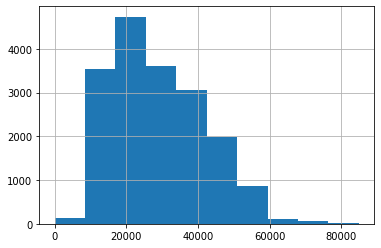

In [56]:
informator(data['airports_nearest'])

Данные заявлены как автоматически добавленные<br />
Возможно, пустые данные - если аэропорт очень далеко (более 80 км)

###### Каких данных нет?
Всего населенных пунктов

In [57]:
len(data['city_name'].unique())

304

Населенных пунктов, для которых не указано расстояние до аэропортов

In [58]:
aero_no = data[data['airports_nearest'].isna()]['city_name'].unique()
len(aero_no)

285

Населенных пунктов, для которых указано расстояние до аэропортов

In [59]:
aero_yes = data[data['airports_nearest'].notna()]['city_name'].unique()
len(aero_yes)

27

Н.п., в которых есть как квартиры, для которых указано расстояние, так и те, для которых не указано

In [60]:
aero_yes_no = pd.Series(list(set(aero_yes).intersection(set(aero_no))))
aero_yes_no

0    Санкт-Петербург
1            Колпино
2          Ломоносов
3             Шушары
4            Щеглово
5       Красное Село
6          Кронштадт
7             Мурино
dtype: object

###### Нулевое расстояние

In [61]:
data.query('airports_nearest < 1000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type
21085,0,"7,000,000.00",34.70,2018-09-23T00:00:00,1,2.70,9.00,19.80,3,NaN,False,False,6.00,2.00,Санкт-Петербург,0.00,"22,801.00",0.00,NaN,0.00,NaN,60.00,Санкт-Петербург,город,городской


Заменим это расстояние на медианное для СПб

In [62]:
data.loc[data['airports_nearest'] == 0,'airports_nearest'] = \
data.loc[data['city_name']  == 'Санкт-Петербург','airports_nearest'].median()

###### Обработка данных
Подстановка расстояний как медианное для всех объявлений в каждом из этих н.п.

In [63]:
for city in aero_yes_no:
    data.loc[(data['city_name'] == city) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['city_name'] == city), 'airports_nearest'].median()

In [64]:
data[data['airports_nearest'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type
5,10,"2,890,000.00",30.40,2018-09-10T00:00:00,1,NaN,12.00,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.00,Янино-1,посёлок городского типа,городской
12,10,"3,890,000.00",54.00,2016-06-30T00:00:00,2,NaN,5.00,30.00,5,NaN,False,False,9.00,0.00,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.00,Сертолово,город,городской
22,20,"5,000,000.00",58.00,2017-04-24T00:00:00,2,2.75,25.00,30.00,15,NaN,False,False,11.00,2.00,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.00,Кудрово,город,городской
30,12,"2,200,000.00",32.80,2018-02-19T00:00:00,1,NaN,9.00,NaN,2,NaN,False,False,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.00,Коммунар,город,городской
37,10,"1,990,000.00",45.80,2017-10-28T00:00:00,2,2.50,5.00,NaN,1,NaN,False,False,NaN,NaN,посёлок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.00,Красный Бор,посёлок городского типа,городской


In [65]:
data['airports_nearest'].notna().sum()

18821

###### Уличная магия или доп.данные
Подгружаю с Яндекс-диска данные по расстояниям от центров населенных пунктов до аэропорта "Пулково" (столбец 'aero') и центра СПб (столбец 'center'). <br />
(Этот набор данных выгружен из  из ГИС ArcGIS и дополнен вручную на основании Яндекс-карт)


In [66]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/hu-UR3KKBFGKIQ' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
# загружаем файл в df 
download_response = requests.get(download_url) 
city_data = pd.read_csv(download_url) 

In [67]:
city_data

,city_name,aero,center
0,1-е Немятово,"121,436.00","121,340.00"
1,1-й Полигон,"120,013.00","133,092.00"
2,2-е Немятово,"120,640.00","120,663.00"
3,2-й Полигон,"120,088.00","133,076.00"
4,34-й Километр,"21,484.30","35,485.10"
...,...,...,...
2625,имени Свердлова,"27,536.70","33,577.40"
2626,Тельмана,"20,927.40","31,970.20"
2627,Лесоуч.23км,"293,421.00","290,680.00"
2628,Озеро-Село,"273,744.00","278,980.00"


Удаляем дубликаты в данных:

In [68]:
city_data = city_data.drop_duplicates(subset=['city_name'])

Объединяем датафреймы:

In [69]:
data = data.merge(city_data,on='city_name', how='left')

In [70]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type,aero,center
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN,Санкт-Петербург,город,городской,NaN,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00,Шушары,посёлок,сельский,NaN,NaN
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00,Санкт-Петербург,город,городской,NaN,NaN
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00,Санкт-Петербург,город,городской,NaN,NaN
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00,Санкт-Петербург,город,городской,NaN,NaN


Дозаполним данные по расстоянию до аэропорта

In [71]:
data['airports_nearest'] = data['airports_nearest'].fillna(data['aero'])

Проверим на пропуски:

In [72]:
data['airports_nearest'].isna().sum()

0

###### Поиск аномалий

Построим гистограмму данных и посмотрим их описание:

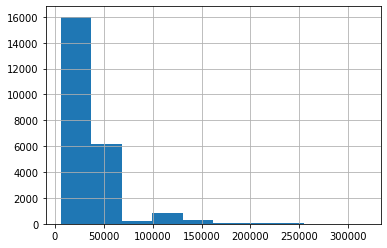

In [73]:
data['airports_nearest'].hist();

In [74]:
data['airports_nearest'].describe()

count    23,650.00
mean     35,803.94
std      27,644.22
min       6,060.00
25%      19,828.25
50%      30,005.50
75%      42,064.00
max     317,505.00
Name: airports_nearest, dtype: float64

На гистограмме есть 2 пика:один очевидный, на расстоянии около 30 км, и второй, где-то в районе 90-160 км

Рассмотрим этот второй пик:

In [75]:
mid_aero = data[(data['airports_nearest'] > 90000) & (data['airports_nearest'] < 160000)] \
.pivot_table(index='city_name', values='airports_nearest',aggfunc=['count','min','max'])
mid_aero.columns = ['count','min','max']
mid_aero.sort_values(by='count', ascending=False).head(20)

,count,min,max
city_name,,,
Выборг,237,"123,449.00","123,449.00"
Кириши,125,"107,047.00","107,047.00"
Сланцы,112,"145,197.00","145,197.00"
Волхов,111,"115,769.00","115,769.00"
Кингисепп,104,"106,161.00","106,161.00"
Приозерск,66,"138,193.00","138,193.00"
Луга,56,"123,890.00","123,890.00"
Ивангород,28,"125,000.00","125,000.00"
Новоселье,28,"105,900.00","105,900.00"


Эти данные относятся к крупным н.п. и не являются аномалиями

Посмотрим, откуда эти данные? <br />
Подключим доп.данные из ГИС

In [76]:
mid_aero = mid_aero.merge(city_data,on='city_name', how='left')

In [77]:
mid_aero.sort_values(by='count', ascending=False).head(20)

,city_name,count,min,max,aero,center
9,Выборг,237,"123,449.00","123,449.00","123,449.00","137,233.00"
27,Кириши,125,"107,047.00","107,047.00","107,047.00","115,651.00"
63,Сланцы,112,"145,197.00","145,197.00","145,197.00","150,145.00"
8,Волхов,111,"115,769.00","115,769.00","115,769.00","118,251.00"
25,Кингисепп,104,"106,161.00","106,161.00","106,161.00","110,117.00"
53,Приозерск,66,"138,193.00","138,193.00","138,193.00","124,043.00"
36,Луга,56,"123,890.00","123,890.00","123,890.00","137,069.00"
21,Ивангород,28,"125,000.00","125,000.00","125,000.00","134,000.00"
42,Новоселье,28,"105,900.00","105,900.00","105,900.00","116,885.00"
68,Сясьстрой,24,"132,143.00","132,143.00","132,143.00","132,009.00"


Данные в столбцах min, max и aero совпадают, значит, все эти данные - значения из ГИС, подставленные вместо пустых значений.<br />
Это подтверждает правильность решения об их использовании: иначе был бы пропущен больщой набор данных

Рассмотрим данные с расстоянием более 160 км

In [78]:
far_aero = data[data['airports_nearest'] > 160000] \
.pivot_table(index='city_name', values='airports_nearest',aggfunc=['count','min','max'])
far_aero.columns = ['count','min','max']
far_aero.sort_values(by='count', ascending=False)


,count,min,max
city_name,,,
Тихвин,49,"183,380.00","183,380.00"
Лодейное Поле,20,"209,440.00","209,440.00"
Подпорожье,19,"249,082.00","249,082.00"
Пикалёво,18,"217,302.00","217,302.00"
Бокситогорск,16,"205,713.00","205,713.00"
Светогорск,11,"165,965.00","165,965.00"
Никольский,7,"244,127.00","244,127.00"
Важины,6,"244,019.00","244,019.00"
Ефимовский,3,"250,319.00","250,319.00"


Сравним эти расстояния с данными из ГИС

In [79]:
far_aero = far_aero.merge(city_data,on='city_name', how='left')

In [80]:
far_aero.sort_values(by='count')

,city_name,count,min,max,aero,center
17,Ялгино,1,"173,654.00","173,654.00","173,654.00","178,603.00"
2,Вахнова Кара,1,"174,644.00","174,644.00","174,644.00","172,062.00"
15,Цвылёво,1,"166,427.00","166,427.00","166,427.00","171,551.00"
16,Шугозеро,1,"221,952.00","221,952.00","221,952.00","224,586.00"
12,Свирьстрой,1,"221,567.00","221,567.00","221,567.00","217,600.00"
3,Вознесенье,2,"317,505.00","317,505.00","317,505.00","314,335.00"
7,Паша,2,"166,926.00","166,926.00","166,926.00","164,888.00"
13,Совхозный,2,"229,606.00","229,606.00","229,606.00","235,074.00"
11,Свирь,2,"192,468.00","192,468.00","192,468.00","191,724.00"
4,Ефимовский,3,"250,319.00","250,319.00","250,319.00","255,590.00"


Данные в столбцах min, max и aero также совпадают. Следовательно, они не аномальные, а просто далеко расположенные.

###### Итоги
- пропущенные данные заполнены медианными значениями данных по тем же населенным пунктам
- оставшиеся пропуски заполненны данными из внешнего источника
- в результате пропущенных данных не осталось
- аномальных данных не обнаружено
- подтверждена верность решения об использовании доп. данных из ГИС

##### **cityCenters_nearest** — расстояние до центра города (м) #####

Описание данных:
count   18,139.00
mean    14,197.86
std      8,606.83
min        181.00
25%      9,241.00
50%     13,105.00
75%     16,293.00
max     65,968.00
Name: cityCenters_nearest, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


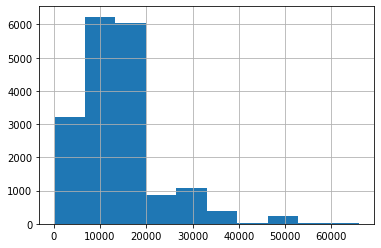

In [81]:
informator(data['cityCenters_nearest'])

Эти данные заявлены как автоматически добавленные.
Есть пик в районе 50 км - возможно, крупный райцентр

###### Каких данных нет?

In [82]:
data[data['cityCenters_nearest'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type,aero,center
5,10,"2,890,000.00",30.40,2018-09-10T00:00:00,1,NaN,12.00,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,"23,337.60",NaN,NaN,NaN,NaN,NaN,55.00,Янино-1,посёлок городского типа,городской,"23,337.60","19,922.40"
8,20,"2,900,000.00",33.16,2018-05-23T00:00:00,1,NaN,27.00,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,"51,553.00",NaN,NaN,NaN,NaN,NaN,189.00,Мурино,город,городской,"29,606.30","19,427.60"
12,10,"3,890,000.00",54.00,2016-06-30T00:00:00,2,NaN,5.00,30.00,5,NaN,False,False,9.00,0.00,Сертолово,"38,658.80",NaN,NaN,NaN,NaN,NaN,90.00,Сертолово,город,городской,"38,658.80","24,412.30"
22,20,"5,000,000.00",58.00,2017-04-24T00:00:00,2,2.75,25.00,30.00,15,NaN,False,False,11.00,2.00,деревня Кудрово,"18,002.00",NaN,NaN,NaN,NaN,NaN,60.00,Кудрово,город,городской,"18,002.00","16,861.10"
30,12,"2,200,000.00",32.80,2018-02-19T00:00:00,1,NaN,9.00,NaN,2,NaN,False,False,NaN,NaN,Коммунар,"21,002.80",NaN,NaN,NaN,NaN,NaN,63.00,Коммунар,город,городской,"21,002.80","35,412.70"


Непонятно, расстоение до центра какого города имеется в виду? Н.п. или СПб?

In [83]:
data.pivot_table(index='city_name', values='cityCenters_nearest')

,cityCenters_nearest
city_name,
Александровская,"27,468.00"
Белоостров,"38,868.00"
Зеленогорск,"54,617.58"
Колпино,"32,113.77"
Красное Село,"30,020.28"
...,...
Сестрорецк,"34,624.48"
Стрельна,"23,376.11"
Усть-Ижора,"28,222.50"


Похоже, что имеется в ввиду растояние до центра СПб

###### Обработка данных 
Поступим с данными аналогично расстоянию с аэропортом. 

Населенных пунктов, для которых не указано расстояние до центра СПб

In [84]:
center_no = data[data['cityCenters_nearest'].isna()]['city_name'].unique()
len(center_no)

286

Населенных пунктов, для которых указано расстояние до аэропортов

In [85]:
center_yes = data[data['cityCenters_nearest'].notna()]['city_name'].unique()
len(center_yes)

27

Н.п., в которых есть как квартиры, для которых указано расстояние, так и те, для которых не указано

In [86]:
center_yes_no = pd.Series(list(set(center_yes).intersection(set(center_no))))
center_yes_no

0    Санкт-Петербург
1            Колпино
2          Ломоносов
3             Шушары
4            Щеглово
5             Пушкин
6       Красное Село
7          Кронштадт
8             Мурино
dtype: object

In [87]:
aero_yes_no = pd.Series(list(set(aero_yes).intersection(set(aero_no))))
aero_yes_no

0    Санкт-Петербург
1            Колпино
2          Ломоносов
3             Шушары
4            Щеглово
5       Красное Село
6          Кронштадт
7             Мурино
dtype: object

В старую компанию присоединился Пушкин.....

Подстановка расстояний как медианное для всех объявлений в каждом из этих н.п.

In [88]:
for city in aero_yes_no:
    data.loc[(data['city_name'] == city) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['city_name'] == city), 'cityCenters_nearest'].median()

In [89]:
data[data['cityCenters_nearest'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type,aero,center
5,10,"2,890,000.00",30.40,2018-09-10T00:00:00,1,NaN,12.00,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,"23,337.60",NaN,NaN,NaN,NaN,NaN,55.00,Янино-1,посёлок городского типа,городской,"23,337.60","19,922.40"
12,10,"3,890,000.00",54.00,2016-06-30T00:00:00,2,NaN,5.00,30.00,5,NaN,False,False,9.00,0.00,Сертолово,"38,658.80",NaN,NaN,NaN,NaN,NaN,90.00,Сертолово,город,городской,"38,658.80","24,412.30"
22,20,"5,000,000.00",58.00,2017-04-24T00:00:00,2,2.75,25.00,30.00,15,NaN,False,False,11.00,2.00,деревня Кудрово,"18,002.00",NaN,NaN,NaN,NaN,NaN,60.00,Кудрово,город,городской,"18,002.00","16,861.10"
30,12,"2,200,000.00",32.80,2018-02-19T00:00:00,1,NaN,9.00,NaN,2,NaN,False,False,NaN,NaN,Коммунар,"21,002.80",NaN,NaN,NaN,NaN,NaN,63.00,Коммунар,город,городской,"21,002.80","35,412.70"
37,10,"1,990,000.00",45.80,2017-10-28T00:00:00,2,2.50,5.00,NaN,1,NaN,False,False,NaN,NaN,посёлок городского типа Красный Бор,"26,538.40",NaN,NaN,NaN,NaN,NaN,196.00,Красный Бор,посёлок городского типа,городской,"26,538.40","37,908.50"


In [90]:
data['cityCenters_nearest'].notna().sum()

18820

###### Доп. данные
Применяем доп.данные, описанные при обработке данных о расстоянии до аэропорта

In [91]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['center'])

In [92]:
data['cityCenters_nearest'].isna().sum()

0

###### Поиск аномалий

Построим гистограмму данных и посмотрим их описание:

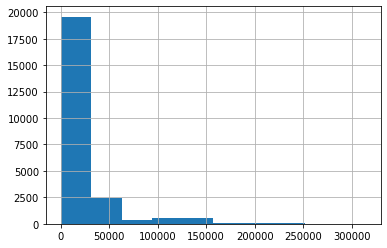

In [93]:
data['cityCenters_nearest'].hist();

In [94]:
data['cityCenters_nearest'].describe()

count    23,650.00
mean     24,172.71
std      30,417.54
min         181.00
25%      10,939.00
50%      14,953.50
75%      23,831.00
max     314,335.00
Name: cityCenters_nearest, dtype: float64

На гистограмме так же, как и в данных по  расстояниям до аэропорта,  есть 2 пика: один очевидный, на расстоянии около 30 км, и второй, где-то в районе 90-160 км

Рассмотрим этот второй пик:

In [95]:
mid_city = data[(data['cityCenters_nearest'] > 90000) & (data['cityCenters_nearest'] < 160000)] \
.pivot_table(index='city_name', values='cityCenters_nearest',aggfunc=['count','min','max'])
mid_city.columns = ['count','min','max']
mid_city.sort_values(by='count', ascending=False).head(20)

,count,min,max
city_name,,,
Выборг,237,"137,233.00","137,233.00"
Кириши,125,"115,651.00","115,651.00"
Сланцы,112,"150,145.00","150,145.00"
Волхов,111,"118,251.00","118,251.00"
Кингисепп,104,"110,117.00","110,117.00"
Приозерск,66,"124,043.00","124,043.00"
Луга,56,"137,069.00","137,069.00"
Новоселье,28,"116,885.00","116,885.00"
Ивангород,28,"134,000.00","134,000.00"


Эти данные относятся к крупным н.п. и не являются аномалиями

Опять подключим доп.данные из ГИС

In [96]:
mid_city = mid_city.merge(city_data,on='city_name', how='left')

In [97]:
mid_city.sort_values(by='count', ascending=False).head(20)

,city_name,count,min,max,aero,center
9,Выборг,237,"137,233.00","137,233.00","123,449.00","137,233.00"
24,Кириши,125,"115,651.00","115,651.00","107,047.00","115,651.00"
58,Сланцы,112,"150,145.00","150,145.00","145,197.00","150,145.00"
8,Волхов,111,"118,251.00","118,251.00","115,769.00","118,251.00"
22,Кингисепп,104,"110,117.00","110,117.00","106,161.00","110,117.00"
48,Приозерск,66,"124,043.00","124,043.00","138,193.00","124,043.00"
32,Луга,56,"137,069.00","137,069.00","123,890.00","137,069.00"
37,Новоселье,28,"116,885.00","116,885.00","105,900.00","116,885.00"
19,Ивангород,28,"134,000.00","134,000.00","125,000.00","134,000.00"
62,Сясьстрой,24,"132,009.00","132,009.00","132,143.00","132,009.00"


Данные в столбцах min, max и aero совпадают, значит, все эти данные - значения из ГИС, подставленные вместо пустых значений.<br />

Теперь проверим объекты, удаленные дальше 160 км

In [98]:
far_city = data[data['airports_nearest'] > 160000] \
.pivot_table(index='city_name', values='airports_nearest',aggfunc=['count','min','max'])
far_city.columns = ['count','min','max']
far_city.sort_values(by='count', ascending=False)


,count,min,max
city_name,,,
Тихвин,49,"183,380.00","183,380.00"
Лодейное Поле,20,"209,440.00","209,440.00"
Подпорожье,19,"249,082.00","249,082.00"
Пикалёво,18,"217,302.00","217,302.00"
Бокситогорск,16,"205,713.00","205,713.00"
Светогорск,11,"165,965.00","165,965.00"
Никольский,7,"244,127.00","244,127.00"
Важины,6,"244,019.00","244,019.00"
Ефимовский,3,"250,319.00","250,319.00"


Сравним эти расстояния с данными из ГИС

In [99]:
far_aero = far_aero.merge(city_data,on='city_name', how='left')

In [100]:
far_aero.sort_values(by='count', ascending=False)

,city_name,count,min,max,aero_x,center_x,aero_y,center_y
14,Тихвин,49,"183,380.00","183,380.00","183,380.00","188,413.00","183,380.00","188,413.00"
5,Лодейное Поле,20,"209,440.00","209,440.00","209,440.00","205,664.00","209,440.00","205,664.00"
9,Подпорожье,19,"249,082.00","249,082.00","249,082.00","245,067.00","249,082.00","245,067.00"
8,Пикалёво,18,"217,302.00","217,302.00","217,302.00","222,631.00","217,302.00","222,631.00"
0,Бокситогорск,16,"205,713.00","205,713.00","205,713.00","211,682.00","205,713.00","211,682.00"
10,Светогорск,11,"165,965.00","165,965.00","165,965.00","151,918.00","165,965.00","151,918.00"
6,Никольский,7,"244,127.00","244,127.00","244,127.00","239,933.00","244,127.00","239,933.00"
1,Важины,6,"244,019.00","244,019.00","244,019.00","239,564.00","244,019.00","239,564.00"
4,Ефимовский,3,"250,319.00","250,319.00","250,319.00","255,590.00","250,319.00","255,590.00"
7,Паша,2,"166,926.00","166,926.00","166,926.00","164,888.00","166,926.00","164,888.00"


Данные в столбцах min, max и aero также совпадают. Следовательно, они не аномальные, а просто далеко расположенные

###### Итоги
- пропущенные данные заполнены медианными значениями данных по тем же населенным пунктам
- оставшиеся пропуски заполненны данными из внешнего источника
- в результате пропущенных данных не осталось
- аномальных данных не обнаружено

##### **Парки**

######  **parks_around3000** — число парков в радиусе 3 км

Предварительный анализ данных:

Описание данных:
count   18,140.00
mean         0.61
std          0.80
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          3.00
Name: parks_around3000, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


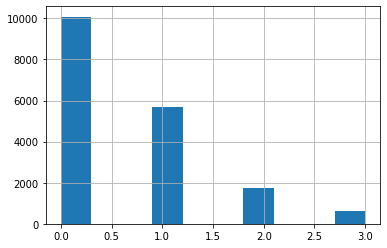

In [101]:
informator(data['parks_around3000'])

Замена пустых значений нулями и приведение данных к типу int

In [102]:
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype('int64')

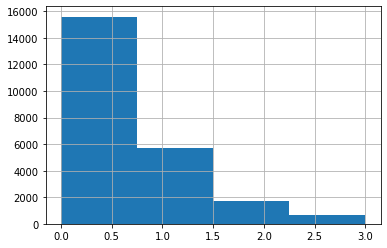

In [103]:
data['parks_around3000'].hist(bins=4);

######  **parks_nearest** — расстояние до ближайшего парка (м)

Предварительный анализ данных:

Описание данных:
count   8,064.00
mean      490.83
std       342.55
min         1.00
25%       288.00
50%       454.50
75%       612.00
max     3,190.00
Name: parks_nearest, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


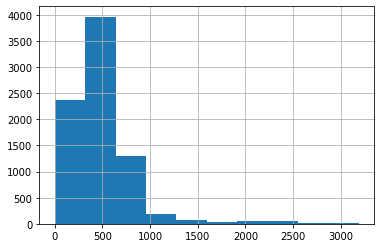

In [104]:
informator(data['parks_nearest'])

Если парка рядом нет - нет и расстояния до него.<br />
Присутствуют парки дальше 3 км

###### Проверка нулевых значений parks_around3000: 
Есть ли среди них те, у которых указано расстояние до парка, и оно больше 3км

In [105]:
len(data.query('parks_around3000 == 0 and parks_nearest.notna() and parks_nearest <= 3000'))

0

Таких объектов нет

###### Проверка расстояний до парков
Есть ли объекты, для которых указаны парки, но нет расстояния до них?

In [106]:
len(data.query('parks_around3000 >0 and parks_nearest.isna()'))

0

Таких объектов нет

##### **Водоёмы**

######  **ponds_around3000** — число водоёмов в радиусе 3 км

Предварительный анализ данных:

Описание данных:
count   18,140.00
mean         0.77
std          0.94
min          0.00
25%          0.00
50%          1.00
75%          1.00
max          3.00
Name: ponds_around3000, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


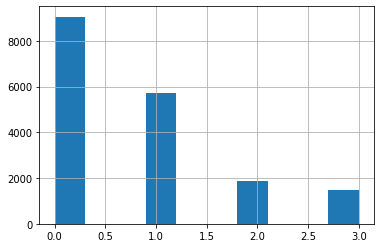

In [107]:
informator(data['ponds_around3000'])

Замена пустых значений нулями и приведение данных к типу int

In [108]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype('int64')

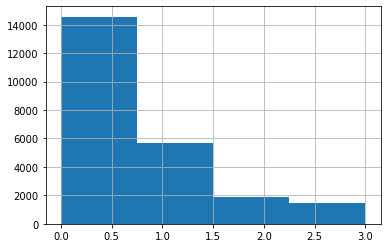

In [109]:
data['ponds_around3000'].hist(bins=4);

######  **ponds_nearest** — расстояние до ближайшего водоёма (м)

Предварительный анализ данных:

Описание данных:
count   9,085.00
mean      518.06
std       277.84
min        13.00
25%       293.00
50%       502.00
75%       730.00
max     1,344.00
Name: ponds_nearest, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


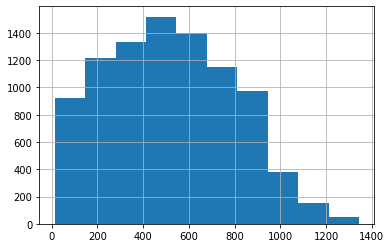

In [110]:
informator(data['ponds_nearest'])

Если водоёма рядом нет - нет и расстояния до него

###### Проверка нулевых значений ponds_around3000: 
Есть ли среди них те, у которых указано расстояние до водоёма

In [111]:
len(data.query('ponds_around3000 == 0 and ponds_nearest.notna()'))

0

Таких объектов нет

###### Проверка расстояний до водоёмов
Есть ли объекты, для которых указаны водоёмы, но нет расстояния до них?

In [112]:
len(data.query('ponds_around3000 >0 and ponds_nearest.isna()'))

0

Таких объектов нет

##### Итоги:
- данные по количеству парков и водоёмов приведены к типу int64, пустые значения заполнены 0
- пустые данные по расстоянию до парков и водоёмов не требуют заполнения
- данные проверены на взаимную корректность

#### **Квартиры**

##### **Типы квартир**
Квартиры в базе 4 типов: студии, аппартаменты, свободной планировки и стандартные

######  **is_apartment** — апартаменты (булев тип)

In [113]:
informator(data['is_apartment'], False)

Описание данных:
count      2760
unique        2
top       False
freq       2710
Name: is_apartment, dtype: object

Тип: <class 'float'>


Скорее всего, незаполненные - не аппартаменты<br />

Заменяем все отсутствующие - на False, и преоблазуем столбец в bool

In [114]:
data['is_apartment'] = data['is_apartment'].fillna(False).astype('bool')

In [115]:
data['is_apartment'].isna().sum()

0

###### **studio** — квартира-студия (булев тип)

In [116]:
informator(data['studio'], False)

Описание данных:
count     23650
unique        2
top       False
freq      23501
Name: studio, dtype: object

Тип: <class 'numpy.bool_'>


Коррекция не требуется

###### **open_plan** — свободная планировка (булев тип)

In [117]:
informator(data['open_plan'], False)

Описание данных:
count     23650
unique        2
top       False
freq      23583
Name: open_plan, dtype: object

Тип: <class 'numpy.bool_'>


Коррекция не требуется

###### **standard** - Для удобства введем дополнительный тип объектов

In [118]:
def standard_object(row):
    return not(row['studio'] or row['open_plan'] or row['is_apartment'])

In [119]:
data['standard']= data.apply(standard_object,axis=1)

In [120]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type,aero,center,standard
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,False,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1,482.00,2,755.00,NaN,Санкт-Петербург,город,городской,NaN,NaN,True
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,False,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0,NaN,0,NaN,81.00,Шушары,посёлок,сельский,NaN,NaN,True
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,False,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1,90.00,2,574.00,558.00,Санкт-Петербург,город,городской,NaN,NaN,True
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,False,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2,84.00,3,234.00,424.00,Санкт-Петербург,город,городской,NaN,NaN,True
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,False,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2,112.00,1,48.00,121.00,Санкт-Петербург,город,городской,NaN,NaN,True


In [121]:
informator(data['standard'], False)

Описание данных:
count     23650
unique        2
top        True
freq      23384
Name: standard, dtype: object

Тип: <class 'numpy.bool_'>


###### **object_type** - тип объектов (новый столбец)

Проверка на дубликаты типов

In [122]:
len(data[data['standard']]) + len(data[data['studio']]) + len(data[data['open_plan']]) + len(data[data['is_apartment']])

23650

Дубликатов в типах нет.

Поскольку типы не пересекаются, сведем все типы объектов в один столбец

In [123]:
def type_object(row):
    if row['standard']:
        return 'standard'
    elif row['studio']:
        return 'studio'
    elif row['open_plan']:
        return 'open_plan'
    elif row['is_apartment']:
        return 'apartment'
    else:
        return 'unknown'

In [124]:
data['object_type']= data.apply(type_object,axis=1)

In [125]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type,aero,center,standard,object_type
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,False,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1,482.00,2,755.00,NaN,Санкт-Петербург,город,городской,NaN,NaN,True,standard
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,False,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0,NaN,0,NaN,81.00,Шушары,посёлок,сельский,NaN,NaN,True,standard
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,False,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1,90.00,2,574.00,558.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,False,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2,84.00,3,234.00,424.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,False,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2,112.00,1,48.00,121.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard


In [126]:
informator(data['object_type'])

Описание данных:
count        23650
unique           4
top       standard
freq         23384
Name: object_type, dtype: object

Тип: <class 'str'>


###### Итоги:
- данные, описывающие типы квартир, приведены (где было необходимо) к булевскому типу и заполнены <br />
- введен тип standard для обычных квартир <br />
- введен дополнительный столбец, хранящий тип квартиры

##### **Характеристики квартир**

######  **rooms** — число комнат

**Анализ данных:**

In [127]:
informator(data['rooms'], False)

Описание данных:
count   23,650.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

Тип: <class 'numpy.int64'>


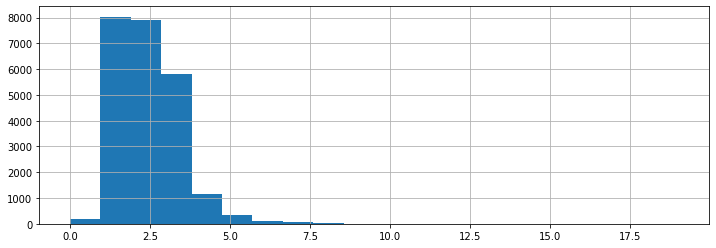

In [128]:
data['rooms'].hist(bins=20,figsize=(12,4));

**Анализ нулевых значений** <br />
В каких типах квартир есть 0?

In [129]:
data.query('rooms == 0').pivot_table(index='object_type', values='rooms', aggfunc='count')

,rooms
object_type,
open_plan,59
studio,138


Посмотрим, какие значения rooms у этих типов:

In [130]:
data.query('object_type == "open_plan"')['rooms'].unique()

array([0, 1, 3, 2, 5, 4])

In [131]:
data.query('object_type == "studio"')['rooms'].unique()

array([0, 1])

У студий 1 комната, значит, можно заполнить значением "1"

In [132]:
data.loc[(data['object_type'] == 'studio') & (data['rooms'] == 0),'rooms'] = 1

Для помещений открытой планировки:

In [133]:
data.query('object_type == "open_plan"').pivot_table(index='rooms',values = 'total_area', 
                                                     aggfunc=['count','median', 'min', 'max', 'mean'])

,count,median,min,max,mean
,total_area,total_area,total_area,total_area,total_area
rooms,,,,,
0,59,26.10,16.00,371.00,32.71
1,3,39.00,36.70,44.20,39.97
2,1,51.00,51.00,51.00,51.00
3,2,61.75,59.00,64.50,61.75
4,1,97.20,97.20,97.20,97.20
5,1,157.00,157.00,157.00,157.00


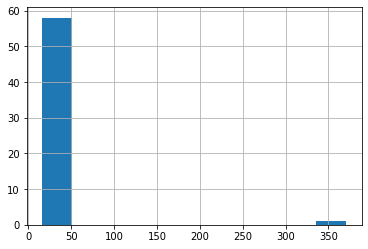

In [134]:
data.query('(object_type == "open_plan") and (rooms == 0)')['total_area'].hist();


In [135]:
data.query('(object_type == "open_plan") and (rooms == 0) and (total_area > 100)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type,aero,center,standard,object_type
19357,5,"71,000,000.00",371.00,2018-07-26T00:00:00,0,3.57,7.00,NaN,6,False,False,True,NaN,NaN,Санкт-Петербург,"25,257.00","6,060.00",1,761.00,1,584.00,90.00,Санкт-Петербург,город,городской,NaN,NaN,False,open_plan


Одно значение. 

Посмотрим, как распределяются значения у всех объектов:

In [136]:
data['rooms'].max()

19

In [137]:
data.pivot_table(index='rooms',values = 'total_area', 
                                                     aggfunc=['count','median', 'min', 'max', 'mean'])

,count,median,min,max,mean
,total_area,total_area,total_area,total_area,total_area
rooms,,,,,
0,59,26.10,16.00,371.00,32.71
1,8174,36.40,12.00,494.10,37.46
2,7924,53.00,20.00,196.00,55.84
3,5797,72.90,40.10,363.10,77.75
4,1175,99.50,42.00,500.00,107.68
5,326,146.45,40.00,507.00,161.47
6,105,184.30,87.00,500.00,201.54
7,59,214.00,100.60,631.20,265.33


Наиболее близкие значения попадают у объектов с 9 комнатами. Будем считать, что и у этого объекта их тоже 9

In [138]:
data.loc[19357,'rooms']=9

Посмотрим еще раз на наши значения:

In [139]:
data.query('object_type == "open_plan"').pivot_table(index='rooms',values = 'total_area', 
                                                     aggfunc=['count','median', 'min', 'max', 'mean'])

,count,median,min,max,mean
,total_area,total_area,total_area,total_area,total_area
rooms,,,,,
0,58,26.10,16.00,42.63,26.87
1,3,39.00,36.70,44.20,39.97
2,1,51.00,51.00,51.00,51.00
3,2,61.75,59.00,64.50,61.75
4,1,97.20,97.20,97.20,97.20
5,1,157.00,157.00,157.00,157.00
9,1,371.00,371.00,371.00,371.00


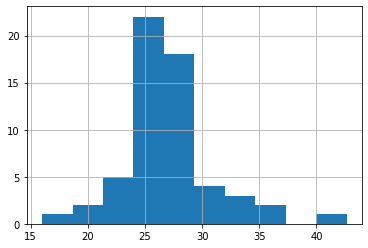

In [140]:
data.query('(object_type == "open_plan") and (rooms == 0)')['total_area'].hist();

Все оставшиеся нули попадают максимум в однокомнатный случай

In [141]:
data.loc[(data['object_type'] == 'open_plan') & (data['rooms'] == 0),'rooms'] = 1

In [142]:
data['rooms'].describe()

count   23,650.00
mean         2.08
std          1.07
min          1.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

**Большое количество комнат**

Посмотрим, распределение количества комнат по объектам

In [143]:
data.pivot_table(index='rooms', values='object_type', aggfunc='count')

,object_type
rooms,
1,8232
2,7924
3,5797
4,1175
5,326
6,105
7,59
8,12
9,9


Посмотрим на квартиры с числом комнат больше 6. Есть ли из них те, у которых маленькая площадь, например, меньше 100 кв.м?

In [144]:
len(data.query('rooms >6 and total_area <100'))

0

Таких нет. Похоже, что анамальные значения здесь отсутствуют.

**Итог:**<br />
Данные скорректированы, аномальные значения отсутствуют

###### **balcony** — число балконов #####

**Посмотрим на данные:**

Описание данных:
count   12,137.00
mean         1.15
std          1.07
min          0.00
25%          0.00
50%          1.00
75%          2.00
max          5.00
Name: balcony, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


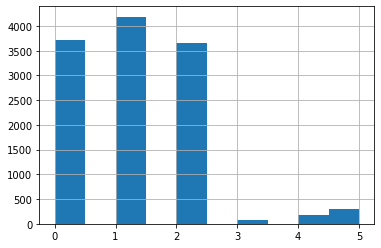

In [145]:
informator(data['balcony'])

Если нет данных о балконах - значит балконов у квартир просто нет

**Заполним отсутствующие значения нулями и приведем их к типу int64**

In [146]:
data['balcony'] = data['balcony'].fillna(0).astype('int64')


In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23649
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        14490 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21752 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  bool   
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          21381 non-null  float64
 13  balcony               23650 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Итог:**
Значения заполнены, тип данных исправлен, аномальные значения отсутствуют

###### **ceiling_height** — высота потолков (м) #####

Описание данных:
count   14,490.00
mean         2.77
std          1.26
min          1.00
25%          2.52
50%          2.65
75%          2.80
max        100.00
Name: ceiling_height, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


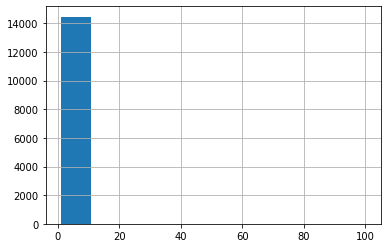

In [148]:
informator(data['ceiling_height'])

**Достоверность данных**<br />
Посмотрим уникальные значения

In [149]:
np.sort(data['ceiling_height'].unique())

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Выделяются очень маленькие (меньше 2 и очень большие значения (20, и больше) <br />
Попробуем соотнести их с ценами на квартиры

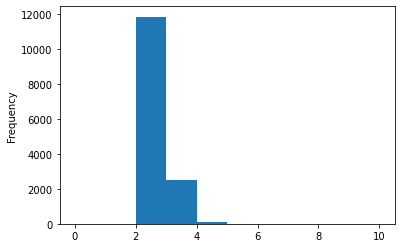

In [150]:
data[data['ceiling_height'].notna()]['ceiling_height'].plot(kind='hist', range=(0,10));

**Заполняем пропуски медианными значениями**

In [151]:
data.loc[(data['ceiling_height'].isna()), 'ceiling_height'] = data['ceiling_height'].median()

In [152]:
data['ceiling_height'].isna().sum() #Проверяем заполненность

0

**Рассмотрим потолки до 2м**

In [153]:
data[data['ceiling_height']<2].groupby('ceiling_height')['ceiling_height'].count()

ceiling_height
1.00    1
1.20    1
1.75    1
Name: ceiling_height, dtype: int64

In [154]:
data[['ceiling_height', 'total_images', 'last_price', 'total_area', 
       'rooms', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'days_exposition', 'city_name',
       'city_type']].query('ceiling_height<2').sort_values(by='ceiling_height')

,ceiling_height,total_images,last_price,total_area,rooms,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,days_exposition,city_name,city_type
22544,1.00,16,"6,000,000.00",55.00,2,12.00,32.40,7,False,False,False,10.00,0,13.00,Санкт-Петербург,город
5702,1.20,5,"1,500,000.00",42.80,2,2.00,27.50,1,False,False,False,5.20,0,248.00,Мга,посёлок городского типа
16904,1.75,5,"4,100,000.00",40.00,1,37.00,17.40,5,False,False,False,8.34,0,71.00,Санкт-Петербург,город


В Санкт-Петербурге только 1 дом высотой 37 этажей - Жилой комплекс «Князь Александр Невский». <br />
Высота потолков в нем составляет 2.65 м. <br /?>
В остальных объектах заменяем высоту на медианное значение

Значение медианы:

In [155]:
ceiling_height_median = data['ceiling_height'].median()
ceiling_height_median

2.65

Поскольку два этих значения совпали, заполняем все медианным значением

In [156]:
data.loc[data['ceiling_height'] < 2,'ceiling_height'] = ceiling_height_median
len(data[data['ceiling_height'] < 2])

0

**Посмотрим на верхний диапазон:**

In [157]:
data[data['ceiling_height']>4]['ceiling_height'].unique()

array([  4.15,  25.  ,   5.2 ,   5.3 ,   5.  ,   4.06,   4.7 ,   5.6 ,
         4.19,   4.8 ,   4.5 ,   4.2 ,  32.  ,   8.  ,   4.37,  27.  ,
         4.1 ,  24.  ,  26.  ,   8.3 ,   4.4 ,   4.45,   5.5 ,   4.3 ,
         4.65,  14.  ,   4.14,   4.25,  20.  ,   6.  ,  22.6 ,   5.8 ,
        27.5 ,   4.9 ,  10.3 , 100.  ])

Значения от 20 до 32 - скорее всего, опечатки, забыли поставить запятую, их стоит разделить на 10

In [158]:
data.loc[(data['ceiling_height'] >= 20.0) & (data['ceiling_height'] <= 32.0), 'ceiling_height'] = \
data.loc[(data['ceiling_height'] >= 20.0) & (data['ceiling_height'] <= 32.0), 'ceiling_height']/10

In [159]:
data[data['ceiling_height']>4]['ceiling_height'].unique()

array([  4.15,   5.2 ,   5.3 ,   5.  ,   4.06,   4.7 ,   5.6 ,   4.19,
         4.8 ,   4.5 ,   4.2 ,   8.  ,   4.37,   4.1 ,   8.3 ,   4.4 ,
         4.45,   5.5 ,   4.3 ,   4.65,  14.  ,   4.14,   4.25,   6.  ,
         5.8 ,   4.9 ,  10.3 , 100.  ])

Потолки до 7 м вполне реальны. Посмотрим, что выше?

In [160]:
data[data['ceiling_height']>7].groupby('ceiling_height')['ceiling_height'].count().sort_values(ascending=False)

ceiling_height
8.00      3
8.30      1
10.30     1
14.00     1
100.00    1
Name: ceiling_height, dtype: int64

Посмотрим данные об этих объектах

In [161]:
data[['ceiling_height', 'total_images', 'last_price', 'total_area', 
       'rooms', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'days_exposition', 'city_name',
       'city_type']].query('ceiling_height>7').sort_values(by='ceiling_height')

,ceiling_height,total_images,last_price,total_area,rooms,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,days_exposition,city_name,city_type
3470,8.00,3,"1,400,000.00",30.00,1,5.00,15.30,2,False,False,False,7.30,0,125.00,Нурма,деревня
15717,8.00,14,"5,600,000.00",67.00,3,16.00,41.00,1,False,False,False,8.00,0,474.00,Санкт-Петербург,город
17412,8.00,0,"5,350,000.00",54.00,2,5.00,29.00,2,False,False,False,NaN,1,469.00,Красное Село,город
5853,8.30,20,"5,650,000.00",45.00,1,16.00,19.30,14,False,False,False,8.30,1,14.00,Санкт-Петербург,город
22264,10.30,20,"5,300,000.00",45.00,1,16.00,15.50,15,False,False,False,NaN,0,136.00,Санкт-Петербург,город
15036,14.00,19,"5,600,000.00",56.40,2,14.00,32.40,5,False,False,False,9.10,2,315.00,Санкт-Петербург,город
22822,100.00,0,"15,000,000.00",25.00,1,5.00,14.00,5,True,False,False,11.00,5,19.00,Санкт-Петербург,город


Объект со 100 м потолком стоит 15 млн при площади 25 кв.м Скорее всего, там тоже опечатка, и высота потолков 10 м. Тем более - это аппартаменты<br />
А вот объект с потолками 10.3 м на 15-м этаже 16-этажного дома нереален. 
Так же, как и объект с потолками 14 м на 5-м этаже 14-этажного дома. 
Скорее всего, неправильные данные. Заменим их медианой<br />
Один из объектов с потолками 8 м расположен в деревне Нурма, где самые высокие дома - хрущевки, средняя высота потолков в которых - 2,5 м. Поскольку дом 5 - этажный, видимо, так оно и есть.
Объект в Красном селе не похож по цене и площади на двухуровневое жилье. Скорее всего, тоже неверные данные - заменим медианой.


In [162]:
def ceiling_height_reducer(row):
    if row['ceiling_height'] >7:
        if row['ceiling_height'] == 100.0:
            row['ceiling_height'] = 10.0
        elif (row['floors_total'] >=14 and row['floors_total'] <=16) or row['city_name'] == 'Красное Село':
            row['ceiling_height'] = ceiling_height_median
        elif row['city_name'] == 'Нурма':
            row['ceiling_height'] = 2.5
    return row    

In [163]:
data = data.apply(ceiling_height_reducer,axis=1)

In [164]:
data[['ceiling_height', 'total_images', 'last_price', 'total_area', 
       'rooms', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'days_exposition', 'city_name',
       'city_type']].query('ceiling_height>7').sort_values(by='ceiling_height')

,ceiling_height,total_images,last_price,total_area,rooms,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,days_exposition,city_name,city_type
22822,10.00,0,"15,000,000.00",25.00,1,5.00,14.00,5,True,False,False,11.00,5,19.00,Санкт-Петербург,город


Оставшийся - 1 объект с бывшими 100-метровыми потолками

**Результат**<br />
- пустые данные о высоте потолков заполнены медианным значением
- некорректные данные подправлены или заменены медианным значением

Описание данных:
count   23,650.00
mean         2.70
std          0.23
min          2.00
25%          2.60
50%          2.65
75%          2.70
max         10.00
Name: ceiling_height, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


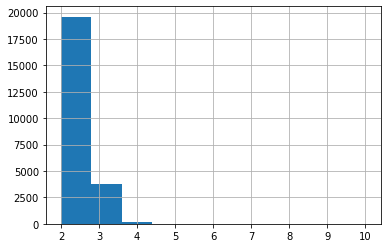

In [165]:
informator(data['ceiling_height'])

##### Итоги
- Исправлены некооректные данные по жилой площади и площади кухни объектов проанализированы, недостающие данные заполнены медианными значениями, с учётом типов жилья и населенных пунктов.Поскольку у студий и помещений свободной планировки отсутствуют выделенные кухни, данные об их площади не заполнялись.
- Скорректированы и заплолнены отсутствующие данные о количестве комнат
- Заплолнены отсутствующие данные о балконах
- Скорректированы и заплолнены отсутствующие данные о высоте потолков

##### **Площади**

###### **total_area** — общая площадь квартиры в квадратных метрах (м²)

Описание данных:
count   23,650.00
mean        60.33
std         35.66
min         12.00
25%         40.00
50%         52.00
75%         69.70
max        900.00
Name: total_area, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


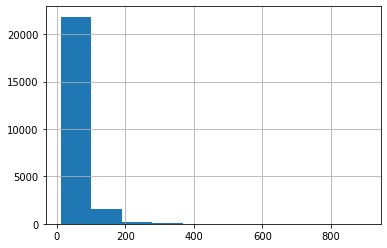

In [166]:
informator(data['total_area'])

Есть объекты с большими площадями. Посмотрим на них:

In [167]:
data.query('total_area > 500')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type,aero,center,standard,object_type
3113,19,"140,000,000.00",631.00,2019-03-30T00:00:00,7,2.65,5.00,NaN,5,False,False,False,60.00,0,Санкт-Петербург,"25,707.00","4,972.00",0,NaN,2,210.00,NaN,Санкт-Петербург,город,городской,NaN,NaN,True,standard
4230,1,"50,000,000.00",517.00,2017-10-14T00:00:00,7,2.65,4.00,332.00,3,False,False,False,22.00,0,Санкт-Петербург,"22,835.00","1,847.00",2,477.00,2,540.00,NaN,Санкт-Петербург,город,городской,NaN,NaN,True,standard
5349,20,"65,000,000.00",590.00,2019-02-14T00:00:00,15,3.50,6.00,409.00,3,False,False,False,100.00,0,Санкт-Петербург,"24,447.00","4,666.00",1,767.00,0,NaN,14.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard
8004,20,"84,000,000.00",507.00,2015-12-17T00:00:00,5,4.45,7.00,301.50,7,True,False,False,45.50,1,Санкт-Петербург,"26,757.75","5,735.00",2,110.00,0,NaN,"1,078.00",Санкт-Петербург,город,городской,NaN,NaN,False,apartment
12840,20,"140,000,000.00",631.20,2019-04-09T00:00:00,7,3.90,4.00,322.30,4,False,False,False,19.50,1,Санкт-Петербург,"25,707.00","4,972.00",0,NaN,2,210.00,NaN,Санкт-Петербург,город,городской,NaN,NaN,True,standard
15626,20,"300,000,000.00",618.00,2017-12-18T00:00:00,7,3.40,7.00,258.00,5,False,False,False,70.00,0,Санкт-Петербург,"32,440.00","5,297.00",0,NaN,2,198.00,111.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard
19505,8,"420,000,000.00",900.00,2017-12-06T00:00:00,12,2.80,25.00,409.70,25,False,False,False,112.00,0,Санкт-Петербург,"30,706.00","7,877.00",0,NaN,2,318.00,106.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard


Не похоже, что это артефакты: остальные параметры пропорциональны

###### Немного информации
В СНИП установлены минимальные значения площадей помещений в квартирах: <br />
- жилая площадь: в однокомнатых квартирах - 14 кв.м, в остальных - 16 кв.м.
- санузел - 3.8 кв. м
- кухня - 5 кв.м
- прихожая - 1 кв. м <br />
В квартирах-студиях и квартирах с открытой планировкой из обязательного присутствует только жилплощадь и санузел.

Зададим эти данные глобальными переменными:

In [168]:
min_live_area_1 = 14.0
min_live_area_2 = 16.0
min_san_area = 3.8
min_kitchen_area = 5.0
min_hall_area = 1.0

Для удобства расчётов добавим технический столбец 'tech_area', содержащий разность общей площади и площадей санузла и прихожей 

In [169]:
def tech_area_calc(row):
    if (row['object_type']=='standard') or (row ['object_type']=='apartment'):
        row['tech_area'] = row['total_area'] - min_san_area - min_hall_area
    if (row['object_type']=='studio') or (row ['object_type']=='open_plan'):
        row['tech_area'] = row['total_area'] - min_san_area
    return row

In [170]:
data = data.apply(tech_area_calc, axis=1)

###### **kitchen_area** — площадь кухни в квадратных метрах (м²)

Описание данных:
count   21,381.00
mean        10.57
std          5.90
min          1.30
25%          7.00
50%          9.10
75%         12.00
max        112.00
Name: kitchen_area, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


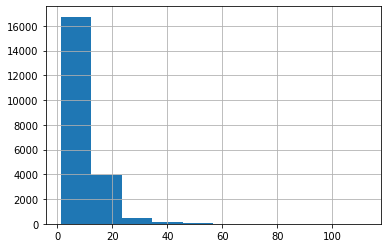

In [171]:
informator(data['kitchen_area'])

Посмотрим на кухни обычных квартир и аппартаментов (у студий и квартир с открытой планировкой их нет)

In [172]:
query_standard = '(object_type == "standard" or object_type == "apartment")'

In [173]:
len(data.query(query_standard + ' and kitchen_area.isna()'))

2053

Заполним площади этих кухонь медианным значением:

In [174]:
data.loc[((data['object_type']=='standard')|(data['object_type']=='apartment')) 
         & (data['kitchen_area'].isna()),'kitchen_area' ] = \
data.loc[((data['object_type']=='standard')|(data['object_type']=='apartment')),'kitchen_area'].median()


Проверим теперь эти данные на наличие кухонь площадью меньше 5 кв.м

In [175]:
len(data.query(query_standard + ' and kitchen_area < @min_kitchen_area'))

105

Заменим их значения на минимальные

In [176]:
data.loc[((data['object_type']=='standard')|(data['object_type']=='apartment')) 
         & (data['kitchen_area'] < min_kitchen_area), 'kitchen_area'] = min_kitchen_area

In [177]:
len(data.query(query_standard + ' and kitchen_area < @min_kitchen_area'))

0

Все данные заменены

In [178]:
data.query(query_standard)['kitchen_area'].describe()

count   23,434.00
mean        10.44
std          5.65
min          5.00
25%          7.30
50%          9.10
75%         11.50
max        112.00
Name: kitchen_area, dtype: float64

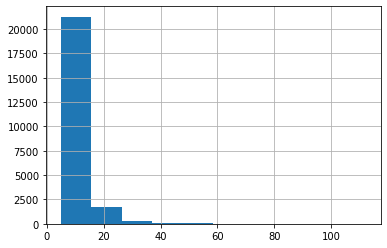

In [179]:
data.query(query_standard)['kitchen_area'].hist();

Присутствуют большие значения, но мы их проверим после работы с жилой площадью

###### **living_area** — жилая площадь в квадратных метрах (м²)

Описание данных:
count   21,752.00
mean        34.45
std         22.04
min          2.00
25%         18.60
50%         30.00
75%         42.30
max        409.70
Name: living_area, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


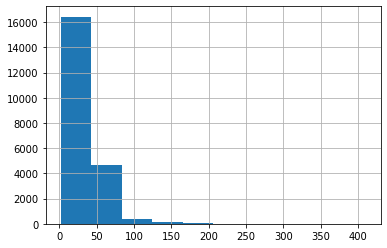

In [180]:
informator(data['living_area'])

In [181]:
data['living_area'].isna().sum()

1898

Пропущено почти 10% данных, нереальное минимальное значение в 2 кв.м. 

**Рассмотрим пропущенные данные в квартирах-студиях и квартирах с открытой планировкой**

In [182]:
query_studio_empty = '(object_type == "studio" or object_type == "open_plan") and living_area.isna()'
data.query(query_studio_empty)[['living_area', 'kitchen_area', 'total_area']]

,living_area,kitchen_area,total_area
608,NaN,NaN,25.00
780,NaN,NaN,26.10
2407,NaN,NaN,27.00
3143,NaN,NaN,31.00
3869,NaN,NaN,21.40
4893,NaN,NaN,24.00
5179,NaN,NaN,25.40
5739,NaN,NaN,25.00
5948,NaN,NaN,30.30
7804,NaN,NaN,27.30


In [183]:
len(data.query(query_studio_empty))

15

Заполним их жилую площадь разницей между общей и минимальной площадью санузла

In [184]:
data.loc[((data['object_type']=='studio')|(data['object_type']=='open_plan')) 
         & (data['living_area'].isna()),'living_area' ] = \
data.loc[((data['object_type']=='studio')|(data['object_type']=='open_plan')) 
         & (data['living_area'].isna()),'total_area'] - min_san_area

In [185]:
len(data.query(query_studio_empty))

0

Если жилая площадь меньше минимальной - заполняем минимальными значениями

In [186]:
def studio_min_living(row):
    global min_live_area_1
    global min_live_area_2
    global min_san_area
    
    if ((row['object_type']=='studio') or (row['object_type']=='open_plan')):
        if (row['rooms'] == 1) and (row['living_area'] < min_live_area_1):
            row['living_area'] = min_live_area_1
        
        if (row['rooms'] > 1) and (row['living_area'] < min_live_area_2):
            row['living_area'] = min_live_area_2
        
        if  row['living_area'] < row['tech_area']:
                row['tech_area'] = row['living_area']
                row['total_area'] = row['tech_area'] + min_san_area
    return row

In [187]:
data = data.apply(studio_min_living, axis=1)

In [188]:
data.iloc[21714][['living_area', 'kitchen_area', 'tech_area', 'rooms', 'object_type']]

living_area      14.00
kitchen_area       NaN
tech_area        14.00
rooms                1
object_type     studio
Name: 21714, dtype: object

**Для обычных квартир и аппартаментов найдем отношение между медианами жилой и общих площадей**

In [189]:
living_median = data['living_area'].median()
living_median

30.0

In [190]:
total_median = data['total_area'].median()
total_median

52.0

In [191]:
living_median/total_median

0.5769230769230769

Заполним пропущенные значения значениями, пропорциональными общей площади

In [192]:
data.loc[((data['object_type']=='standard')|(data['object_type']=='apartment')) 
         & (data['living_area'].isna()),'living_area' ] = \
data.loc[((data['object_type']=='standard')|(data['object_type']=='apartment')),'total_area']*living_median/total_median

In [193]:
len(data.query(query_standard + 'and living_area.isna()'))

0

Проверим отсутствие жилой площади меньше нормы

Для однокомнатных квартир:

In [194]:
len(data.query(query_standard + 'and rooms == 1 and living_area < @min_live_area_1'))

313

Заполним их значением min_live_area_1:

In [195]:
data.loc[((data['object_type']=='standard')|(data['object_type']=='apartment')) &
         (data['rooms'] == 1) & (data['living_area'] < min_live_area_1),'living_area' ] = min_live_area_1

In [196]:
len(data.query(query_standard + 'and rooms == 1 and living_area < @min_live_area_1'))

0

Повторим это же для квартир с большим количеством комнат

In [197]:
len(data.query(query_standard + 'and rooms > 1 and living_area < @min_live_area_2'))

30

In [198]:
data.loc[((data['object_type']=='standard')|(data['object_type']=='apartment')) &
         (data['rooms'] > 1) & (data['living_area'] < min_live_area_2),'living_area' ] = min_live_area_2

In [199]:
len(data.query(query_standard + 'and rooms > 1 and living_area < @min_live_area_2'))

0

Данные заполнены

###### Проверка качества исходных данных

Проверим, есть ли стандартные квартиры и апартаменты, у которых общая площадь меньше предписанного минимума:

In [200]:
data.query(query_standard + ' and tech_area < @min_live_area_1 + @min_kitchen_area and rooms == 1') \
[['living_area', 'kitchen_area', 'tech_area', 'rooms']]

,living_area,kitchen_area,tech_area,rooms
114,14.00,6.30,16.60,1
1193,14.00,9.10,17.90,1
1279,17.00,9.10,18.20,1
1587,14.00,9.10,17.09,1
1607,14.00,9.10,15.30,1
...,...,...,...,...
22311,14.00,9.10,12.40,1
22339,15.00,5.00,17.43,1
22634,17.70,9.10,18.80,1
23143,16.00,9.10,14.10,1


In [201]:
data.query(query_standard + ' and tech_area < @min_live_area_2 + @min_kitchen_area and rooms > 1') \
[['living_area', 'kitchen_area', 'tech_area', 'rooms']]

,living_area,kitchen_area,tech_area,rooms
4072,16.00,5.60,15.20,2
6252,16.00,5.00,19.20,2


Даже двухкомнатные есть!<br />
Похоже, здесь надо исправить общую площадь, задав СНИПовские значения

In [202]:
data.iloc[7741][['living_area', 'kitchen_area', 'tech_area', 'rooms']]

living_area    14.95
kitchen_area   14.95
tech_area      15.87
rooms              1
Name: 7741, dtype: object

In [203]:
def fix_total(row):
    global min_live_area_1
    global min_live_area_2
    global min_san_area
    global min_kitchen_area
    global min_hall_area
    
    if ((row['object_type']=='standard') or (row['object_type']=='apartment')) \
    and (((row['rooms'] == 1) and (row['tech_area'] < min_live_area_1 + min_kitchen_area)) \
    or ((row['rooms'] > 1) and (row['tech_area'] < min_live_area_2 + min_kitchen_area))):

        if row['living_area'] == row['kitchen_area']:                              #Исключаем опечатки

            if row['rooms'] == 1:
                row['living_area'] = min_live_area_1
            else:
                row['living_area'] = min_live_area_2
            row['kitchen_area'] = min_kitchen_area

        row['tech_area'] = row['living_area'] +row['kitchen_area']
        row['total_area'] = row['tech_area'] + min_san_area + min_hall_area
            
    return row    

In [204]:
data = data.apply(fix_total, axis=1)

In [205]:
len(data.query(query_standard + ' and tech_area < @min_live_area_1 + @min_kitchen_area and rooms == 1') \
[['living_area', 'kitchen_area', 'tech_area', 'rooms']])

0

In [206]:
len(data.query(query_standard + ' and tech_area < @min_live_area_2 + @min_kitchen_area and rooms > 1') \
[['living_area', 'kitchen_area', 'tech_area', 'rooms']])

0

Битые данные исправлены

У стандартных квартир и апартаментов может возникнуть ситуация, сумма помещений будет больше общей. Проверим:

In [207]:
query_bust = query_standard + ' and (living_area + kitchen_area  > tech_area)'

In [208]:
len(data.query(query_bust))

766

In [209]:
data.query(query_bust)[['living_area', 'kitchen_area', 'tech_area']].head(20)

,living_area,kitchen_area,tech_area
30,18.92,9.10,28.00
41,59.00,12.00,69.20
133,17.88,9.10,26.20
143,20.00,5.60,25.20
171,38.00,10.00,44.20
184,26.10,6.20,25.40
220,28.00,9.00,32.20
237,20.75,9.10,23.30
247,17.88,9.10,26.20
304,18.46,9.10,27.20


Проверим на опечатки: равные значения площадей (во всём наборе данных)

In [210]:
data.query('living_area == kitchen_area')[['living_area', 'kitchen_area', 'tech_area']].head(20)

,living_area,kitchen_area,tech_area
443,17.70,17.70,47.60
696,23.43,23.43,29.89
1297,14.70,14.70,38.10
3045,14.00,14.00,32.20
3476,15.00,15.00,38.20
3674,32.00,32.00,75.20
4023,25.00,25.00,53.70
4166,30.00,30.00,69.20
4541,15.00,15.00,37.20
4711,15.00,15.00,34.40


Будем считать что жилая площадь всегда больше площади кухни, если кухня больше половины tech_area, то более правильное значение - в жилой площади 

In [211]:
def calc_equal(row):
    global min_live_area_1
    global min_live_area_2
    global min_san_area
    global min_kitchen_area
    global min_hall_area

    if row['kitchen_area'] == row['living_area']:
        if row['kitchen_area'] > row['tech_area']/2:                     #Если кухня больше
            row['kitchen_area'] = row['tech_area'] - row['living_area']
        else:                                                            #Если жилая больше
            row['kitchen_area'] =  row['tech_area'] - row['kitchen_area']

        if row['kitchen_area'] < min_kitchen_area:                       #Если кухня меньше минимума
            row['kitchen_area'] = min_kitchen_area
            row['living_area'] =  row['tech_area'] - row['kitchen_area']
    return row       

In [212]:
data = data.apply(calc_equal, axis=1)

In [213]:
len(data.query('living_area == kitchen_area')[['living_area', 'kitchen_area', 'tech_area']])

0

"Равные" опечатки убраны

In [214]:
len(data.query(query_bust))

759

Для оставшихся предлагается тот же принцип: уменьшаем кухню, но не меньше минимума.

In [215]:
def calc_bust(row):
    global min_live_area_1
    global min_live_area_2
    global min_san_area
    global min_kitchen_area
    global min_hall_area

    if ((row['object_type']=='standard') or (row['object_type']=='apartment')) \
    and (row['kitchen_area'] + row['living_area'] > row['tech_area']):
        row['kitchen_area'] = row['tech_area'] - row['living_area']
        if row['kitchen_area'] < min_kitchen_area:
            row['kitchen_area'] = min_kitchen_area
            row['living_area'] =  row['tech_area'] - row['kitchen_area']
    return row       

In [216]:
data = data.apply(calc_bust, axis=1)

In [217]:
len(data.query(query_bust))

0

Эти артефакты тоже устранены

###### Итоги:

In [218]:
data[['living_area', 'kitchen_area', 'total_area']].isna().sum()

living_area       0
kitchen_area    216
total_area        0
dtype: int64

- Данные по жилой площади и площади кухни объектов проанализированы
- Некооректные данные исправлены
- Недостающие данные заполнены рассчётными значениями, с учётом типов жилья и населенных пунктов
- Поскольку у студий и помещений свободной планировки отсутствуют выделенные кухни, данные об их площади не заполнялись.

#####  **Этажи**

###### **floors_total** — всего этажей в доме

Описание данных:
count   23,565.00
mean        10.68
std          6.59
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


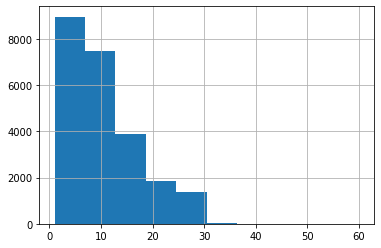

In [219]:
informator(data['floors_total'])

Пропущенных записей:

In [220]:
len(data.query('floors_total.isna()'))

85

Посмотрим, как распределяются этажи квартир в домах, где не указана этажность

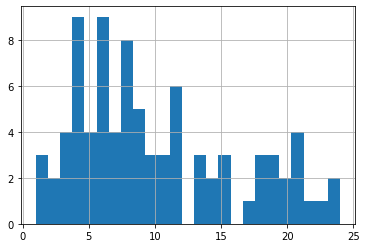

In [221]:
data.query('floors_total.isna()')['floor'].hist(bins=25);

Явных аномалий не наблюдается

Считаю нецелесообразным заполнение пустых значений: точно определить этажность дома нельзя, но потеряется возможность рассчёта влияния последнего этажа на цену
    

Посмотрим на значения:

In [222]:
data['floors_total'].describe()

count   23,565.00
mean        10.68
std          6.59
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         60.00
Name: floors_total, dtype: float64

В Санкт-Петербурге самое высокое жилое здание имеет 37 этажей. Посмотрим на здания, которые выше: 

In [223]:
data.query('floors_total > 37')[['floors_total', 'floor', 'city_name', 'last_price', 'living_area']]

,floors_total,floor,city_name,last_price,living_area
2251,60.00,4,Кронштадт,"3,800,000.00",27.40
16701,52.00,18,Санкт-Петербург,"3,978,000.00",14.00


Считаю целесообразным убрать данные о этажности этих зданий

In [224]:
data.loc[data['floors_total'] > 37, 'floors_total'] = np.nan

######  **floor** — этаж

Описание данных:
count   23,650.00
mean         5.89
std          4.88
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         33.00
Name: floor, dtype: float64

Тип: <class 'numpy.int64'>

Гистограмма значений:


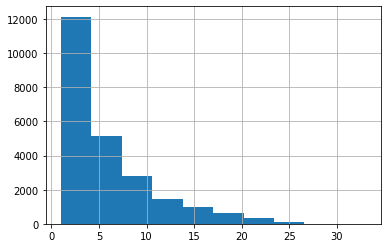

In [225]:
informator(data['floor'])

Пропущенных записей:

In [226]:
len(data.query('floor.isna()'))

0

Проверим отсутсвие нулевых значений:

In [227]:
len(data.query('floor < 1'))

0

Проверим, что все этажи укладываются в высоту домов:

In [228]:
len(data.query('floors_total.isna() and (floor>floors_total)'))

0

###### Итоги:
- Часть данных по этажности отсутствует, корректное заполнение этих данных невозможно
- Данные по этажам объектов корректны

#### **Коммерческая информация**

##### **Размещение объявления**

###### **first_day_exposition** — дата публикации

In [229]:
informator(data['first_day_exposition'])

Описание данных:
count                   23650
unique                   1491
top       2018-02-01T00:00:00
freq                      368
Name: first_day_exposition, dtype: object

Тип: <class 'str'>


Все данные заполнены.<br />
Смена типа данных:

In [230]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,city_name,city_type,big_type,aero,center,standard,object_type,tech_area
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16.00,51.00,8,False,False,False,25.00,0,Санкт-Петербург,"18,863.00","16,028.00",1,482.00,2,755.00,NaN,Санкт-Петербург,город,городской,NaN,NaN,True,standard,103.20
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11.00,18.60,1,False,False,False,11.00,2,посёлок Шушары,"12,817.00","18,603.00",0,NaN,0,NaN,81.00,Шушары,посёлок,сельский,NaN,NaN,True,standard,35.60
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5.00,34.30,4,False,False,False,8.30,0,Санкт-Петербург,"21,741.00","13,933.00",1,90.00,2,574.00,558.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard,51.20
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14.00,91.73,9,False,False,False,9.10,0,Санкт-Петербург,"28,098.00","6,800.00",2,84.00,3,234.00,424.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard,154.20
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14.00,32.00,13,False,False,False,41.00,0,Санкт-Петербург,"31,856.00","8,098.00",2,112.00,1,48.00,121.00,Санкт-Петербург,город,городской,NaN,NaN,True,standard,95.20


###### **days_exposition** — сколько дней было размещено объявление (от публикации до снятия) #####

Описание данных:
count   20,470.00
mean       180.75
std        219.78
min          1.00
25%         45.00
50%         95.00
75%        231.00
max      1,580.00
Name: days_exposition, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


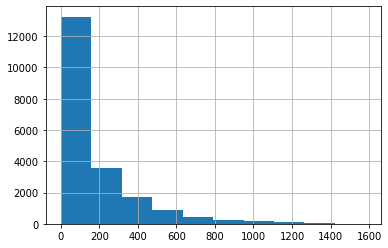

In [231]:
informator(data['days_exposition'])

######  Временно заполним пустые значения чиcлом -1 и приведем к целому

In [232]:
data['days_exposition'] = data['days_exposition'].fillna(-1).astype('int64')

###### Вычисление последней даты размещения объявлений с известным сроком

Поскольку число дней публикации должно вычисляться автоматически, можно предположить, что объявления, у которых нет такой информации, еще не сняты с публикации.
Поскольку архив достаточно старый, вычислим последнюю дату, когда закрывались объявления, и "псевдо-сегодня" - следующий  после этой даты день.

Добавим булевый столбец 'actual' - актуально или нет объявление, и вычислим дату последнего закрытия для неактуальных объявлений

In [233]:
def calc_last_day(row):
    if row['days_exposition']>=0:
        row['last_day_exposition']=row['first_day_exposition'] + pd.Timedelta(days=row['days_exposition'])
        row['actual'] = False # Объявление закрыто
    else:
        row['actual'] = True # Объявление актуально
    return row    

In [234]:
data = data.apply(calc_last_day, axis=1)

In [235]:
last_public_day = data['last_day_exposition'].max()
last_public_day

Timestamp('2019-05-02 00:00:00')

###### Вычисление последнего дня публикации для актуальных обявлений - "псевдо-сегодня" , а также длительности их публикации

"Псевдо-сегодня" - следующий день после выгрузки:

In [236]:
data.loc[data['actual'],'last_day_exposition'] = last_public_day  + pd.Timedelta(days=1)

Срок, который актуальные объявления уже находятся на площадке:

In [237]:
data.loc[data['actual'],'days_exposition'] = \
    (data['last_day_exposition'] - data['first_day_exposition'] + pd.Timedelta(days=1)).dt.days

Описание данных:
count                            23650
mean     2018-05-14 17:12:43.230444032
min                2016-06-16 00:00:00
25%                2017-11-22 00:00:00
50%                2018-06-04 00:00:00
75%                2019-01-14 00:00:00
max                2019-05-03 00:00:00
Name: last_day_exposition, dtype: object

Тип: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

Гистограмма значений:


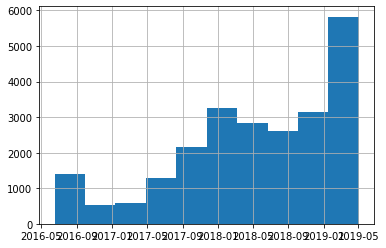

In [238]:
informator(data['last_day_exposition'])

###### Итог: 
Заполнены данные, размечены актуальные и неактуальные объявления

#####  **last_price** — цена на момент снятия с публикации

Описание данных:
count        23,650.00
mean      6,541,126.90
std      10,896,399.18
min          12,190.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,799,000.00
max     763,000,000.00
Name: last_price, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


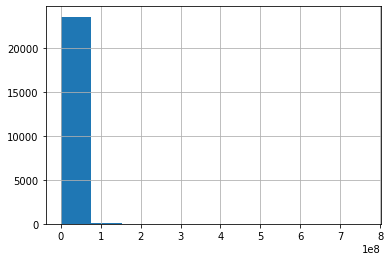

In [239]:
informator(data['last_price'])

Интересно, что это за квартира за 12 190 рублей? Дайте две!

In [240]:
data.query('last_price <400000')

,actual,aero,airports_nearest,balcony,big_type,ceiling_height,center,cityCenters_nearest,city_name,city_type,days_exposition,first_day_exposition,floor,floors_total,is_apartment,kitchen_area,last_day_exposition,last_price,living_area,locality_name,object_type,open_plan,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,rooms,standard,studio,tech_area,total_area,total_images
8778,False,NaN,"36,421.00",0,городской,2.75,NaN,"9,176.00",Санкт-Петербург,город,8,2019-03-20,25,25.00,False,40.50,2019-03-28,"12,190.00",32.00,Санкт-Петербург,standard,False,1,805.00,0,NaN,2,True,False,104.20,109.00,7


Расчитаем медианную цену по Спб:

In [241]:
data.query('(city_name =="Санкт-Петербург") and (total_area >= 100) and (total_area <= 120)' )['last_price'].median()

12800000.0

Похоже, цена данной квартиры указана в тысячах

In [242]:
data.loc[data['last_price'] < 13000,'last_price'] = data.loc[data['last_price'] < 13000,'last_price']*1000

Описание данных:
count        23,650.00
mean      6,541,641.82
std      10,896,378.37
min         430,000.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,799,000.00
max     763,000,000.00
Name: last_price, dtype: float64

Тип: <class 'numpy.float64'>

Гистограмма значений:


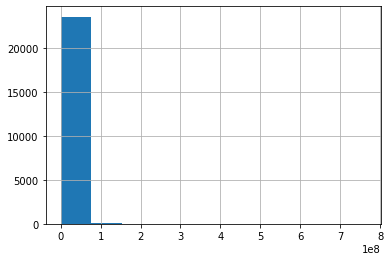

In [243]:
informator(data['last_price'])

Результат: восстановлены некорректные данные

#####  **total_images** — число фотографий квартиры в объявлении

Описание данных:
count   23,650.00
mean         9.86
std          5.68
min          0.00
25%          6.00
50%          9.00
75%         14.00
max         50.00
Name: total_images, dtype: float64

Тип: <class 'numpy.int64'>

Гистограмма значений:


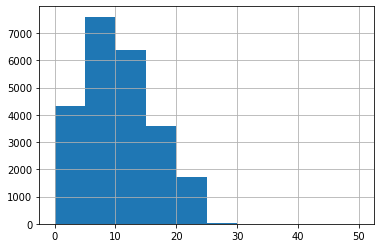

In [244]:
informator(data['total_images'])

Поскольку данные о количестве фотографий формируются самой системой (хочется в это верить), они не требуют верификации

#### Общий вывод по этапу 2

1. За счёт расчётов, жизненного опыта и привлечения внешних данных, удалось сохранить данные об 23650 из 23699 квартир.
Причина, по которой данные максимально не удалялись,в том, что поврежденные  в одном параметре, данные остаются вполне годными для анализа по другим параметрам.
2. Добавлены новые столбцы, которые облегчают проведение предобработки и анализа данных
3. После предобработки данные подготовлены к проведению исследовательского анализа

### Посчитайте и добавьте в таблицу новые столбцы

#### **price_meter** - цена одного квадратного метра

In [245]:
data['price_meter'] = data['last_price'] / data['total_area']

#### **week_first_day** - день публикации объявления (0 - понедельник, 1 - вторник и т.д.)

In [246]:
data['week_first_day'] = data['first_day_exposition'].dt.weekday

 #### **month_first_day** - месяц публикации объявления

In [247]:
data['month_first_day'] = data['first_day_exposition'].dt.month

 #### **year_first_day** - год публикации объявления"

In [248]:
data['year_first_day'] = data['first_day_exposition'].dt.year

 #### **type_floor** - тип этажа квартиры" (значения — «первый», «последний», «другой», «нет данных»)

In [249]:
def floor_typer(row):
    if row['floor'] == 1:
        row['type_floor'] = 'первый'
    elif  math.isnan(row['floors_total']):
        row['type_floor'] = 'нет данных'
    elif row['floor'] == row['floors_total']:
        row['type_floor'] = 'последний'
    else:
        row['type_floor'] = 'другой'
    return row

In [250]:
data = data.apply(floor_typer, axis=1)

#### **center_km** - расстояние в км до центра города

In [251]:
data['center_km'] = (data['cityCenters_nearest']/1000+0.5).astype('int64')

#### **aero_km** - расстояние в км до ближайшего аэропорта

In [252]:
data['aero_km'] = (data['airports_nearest']/1000+0.5).astype('int64')

#### Проверка добавленых столбцов

In [253]:
data.head()

,actual,aero,airports_nearest,balcony,big_type,ceiling_height,center,cityCenters_nearest,city_name,city_type,days_exposition,first_day_exposition,floor,floors_total,is_apartment,kitchen_area,last_day_exposition,last_price,living_area,locality_name,object_type,open_plan,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,rooms,standard,studio,tech_area,total_area,total_images,price_meter,week_first_day,month_first_day,year_first_day,type_floor,center_km,aero_km
0,True,NaN,"18,863.00",0,городской,2.70,NaN,"16,028.00",Санкт-Петербург,город,58,2019-03-07,8,16.00,False,25.00,2019-05-03,"13,000,000.00",51.00,Санкт-Петербург,standard,False,1,482.00,2,755.00,3,True,False,103.20,108.00,20,"120,370.37",3,3,2019,другой,16,19
1,False,NaN,"12,817.00",2,сельский,2.65,NaN,"18,603.00",Шушары,посёлок,81,2018-12-04,1,11.00,False,11.00,2019-02-23,"3,350,000.00",18.60,посёлок Шушары,standard,False,0,NaN,0,NaN,1,True,False,35.60,40.40,7,"82,920.79",1,12,2018,первый,19,13
2,False,NaN,"21,741.00",0,городской,2.65,NaN,"13,933.00",Санкт-Петербург,город,558,2015-08-20,4,5.00,False,8.30,2017-02-28,"5,196,000.00",34.30,Санкт-Петербург,standard,False,1,90.00,2,574.00,2,True,False,51.20,56.00,10,"92,785.71",3,8,2015,другой,14,22
3,False,NaN,"28,098.00",0,городской,2.65,NaN,"6,800.00",Санкт-Петербург,город,424,2015-07-24,9,14.00,False,9.10,2016-09-20,"64,900,000.00",91.73,Санкт-Петербург,standard,False,2,84.00,3,234.00,3,True,False,154.20,159.00,0,"408,176.10",4,7,2015,другой,7,28
4,False,NaN,"31,856.00",0,городской,3.03,NaN,"8,098.00",Санкт-Петербург,город,121,2018-06-19,13,14.00,False,41.00,2018-10-18,"10,000,000.00",32.00,Санкт-Петербург,standard,False,2,112.00,1,48.00,2,True,False,95.20,100.00,2,"100,000.00",1,6,2018,другой,8,32


#### Общий вывод по этапу 3
Необходимые для проведения анализа столбцы сформированы

### Проведите исследовательский анализ данных

##### Изучение параметров объектов:

###### **total_area** — общая площадь квартиры в квадратных метрах (м²)

In [254]:
informator(data['total_area'], False)

Описание данных:
count   23,650.00
mean        60.31
std         35.67
min         15.50
25%         40.00
50%         52.00
75%         69.70
max        900.00
Name: total_area, dtype: float64

Тип: <class 'numpy.float64'>


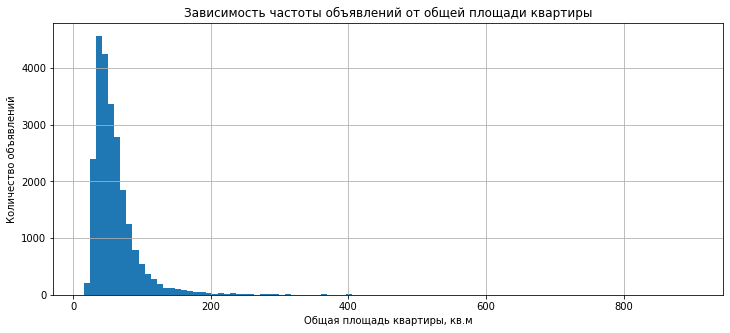

In [255]:
data['total_area'].plot(kind='hist',figsize=(12,5), bins=100, grid = True)
plt.title('Зависимость частоты объявлений от общей площади квартиры')
plt.xlabel('Общая площадь квартиры, кв.м') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Минимальная общая площадь составляет 15,5 кв.м, максимальная - 900 кв.м
- Данные соответствуют распределению Пуассона
- Максимум - в районе 30 кв.м



###### **living_area** — жилая площадь в квадратных метрах (м²)

In [256]:
informator(data['living_area'], False)

Описание данных:
count   23,650.00
mean        34.63
std         22.44
min         14.00
25%         19.00
50%         30.00
75%         42.12
max        409.70
Name: living_area, dtype: float64

Тип: <class 'numpy.float64'>


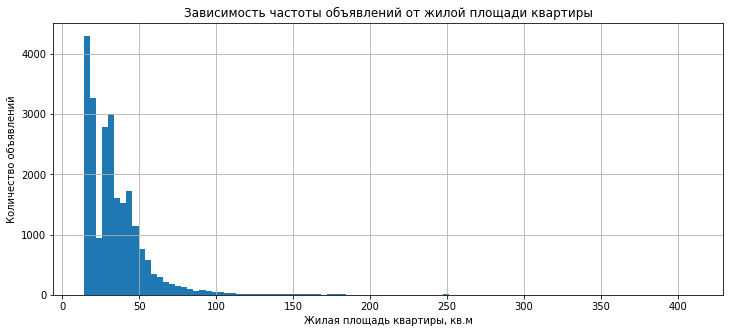

In [257]:
data['living_area'].plot(kind='hist',figsize=(12,5), bins=100, grid = True)
plt.title('Зависимость частоты объявлений от жилой площади квартиры')
plt.xlabel('Жилая площадь квартиры, кв.м') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Минимальная жилая площадь составляет 14 кв.м, максимальная - 409 кв.м
- Данные соответствуют распределению Пуассона
- Максимум - в районе 20 кв.м
- Пики на гистограмме, скорее всего, соответствуют 1,2-х комнатным квартирам


###### **kitchen_area** — площадь кухни в квадратных метрах (м²)

In [258]:
informator(data['kitchen_area'], False)

Описание данных:
count   23,434.00
mean        10.37
std          5.69
min          5.00
25%          7.10
50%          9.10
75%         11.40
max        118.20
Name: kitchen_area, dtype: float64

Тип: <class 'numpy.float64'>


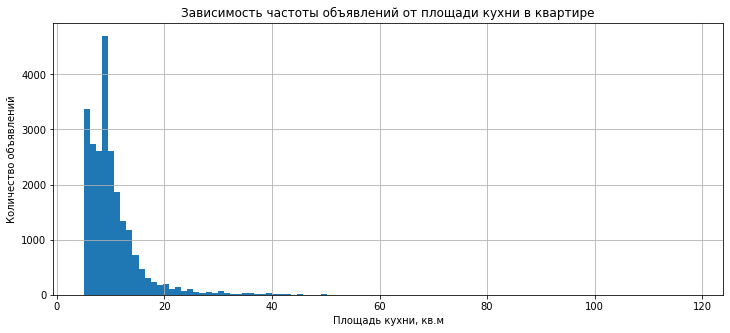

In [259]:
data['kitchen_area'].plot(kind='hist',figsize=(12,5), bins=100, grid = True)
plt.title('Зависимость частоты объявлений от площади кухни в квартире')
plt.xlabel('Площадь кухни, кв.м') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Минимальная площадь кухни составляет 5 кв.м, максимальная - 118 кв.м
- Данные соответствуют распределению Пуассона
- Максимум - в районе 8 кв.м


###### **last_price** — цена на момент снятия с публикации, руб

In [260]:
informator(data['last_price'], False)

Описание данных:
count        23,650.00
mean      6,541,641.82
std      10,896,378.37
min         430,000.00
25%       3,400,000.00
50%       4,650,000.00
75%       6,799,000.00
max     763,000,000.00
Name: last_price, dtype: float64

Тип: <class 'numpy.float64'>


Пересчитаем цену в миллионы рублей:

In [261]:
data['last_price_mln'] = data['last_price']/1000000 

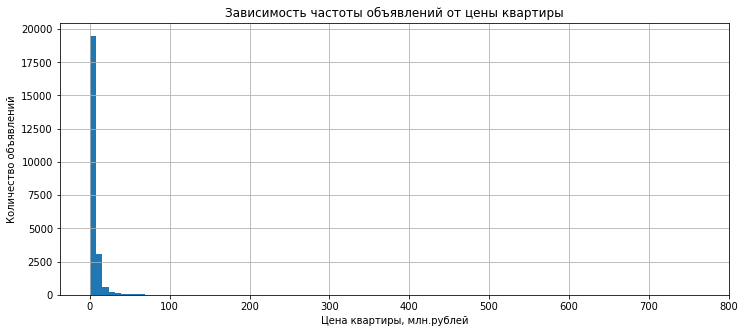

In [262]:
data['last_price_mln'].plot(kind='hist',figsize=(12,5), bins=100, grid = True)
plt.title('Зависимость частоты объявлений от цены квартиры')
plt.xlabel('Цена квартиры, млн.рублей') 
plt.ylabel('Количество объявлений')
plt.show()

Рассмотрим диапазон цен до 20 млн. рублей

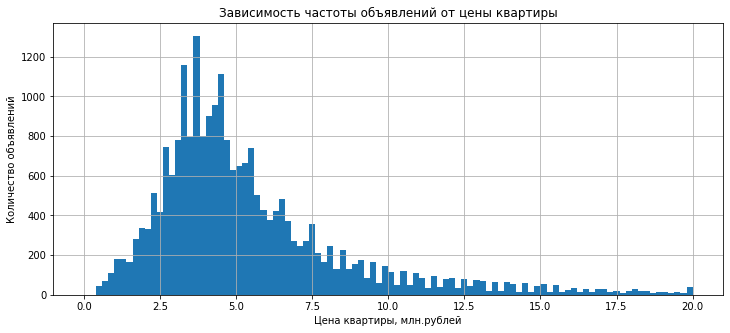

In [263]:
data['last_price_mln'].plot(kind='hist',figsize=(12,5), bins=100, grid = True, range=[0, 20])
plt.title('Зависимость частоты объявлений от цены квартиры')
plt.xlabel('Цена квартиры, млн.рублей') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Минимальная стоимость жилья в выборке составляет 430 тыс.рублей, максимальная - 763 млн. рублей
- Данные соответствуют распределению Пуассона
- Максимум - в районе 3,5 млн.рублей

###### **rooms** - количество комнат

In [264]:
informator(data['rooms'], False)

Описание данных:
count   23,650.00
mean         2.08
std          1.07
min          1.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

Тип: <class 'numpy.int64'>


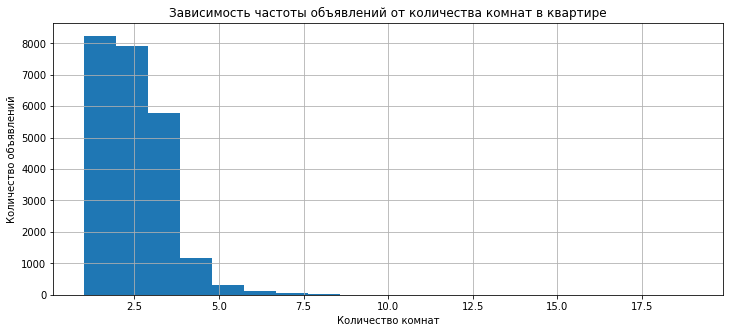

In [265]:
data['rooms'].plot(kind='hist',figsize=(12,5), bins=19, grid = True)
plt.title('Зависимость частоты объявлений от количества комнат в квартире')
plt.xlabel('Количество комнат') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Минимальное количество комнат составляет 1, максимальное - 19
- Данные соответствуют распределению Пуассона
- Максимум составлюяют однокомнатные квартиры

###### **ceiling_height** — высота потолков (м) 

In [266]:
informator(data['ceiling_height'], False)

Описание данных:
count   23,650.00
mean         2.70
std          0.23
min          2.00
25%          2.60
50%          2.65
75%          2.70
max         10.00
Name: ceiling_height, dtype: float64

Тип: <class 'numpy.float64'>


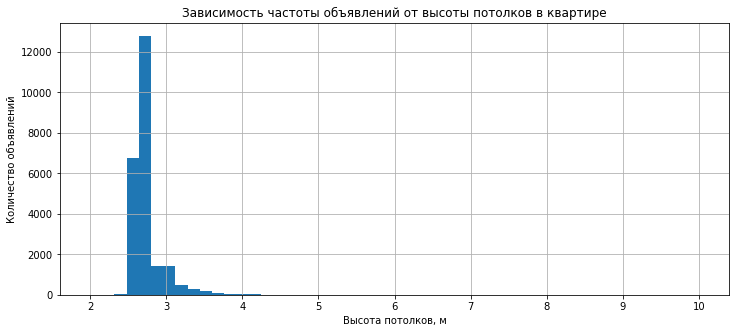

In [267]:
data['ceiling_height'].plot(kind='hist',figsize=(12,5), bins=50, grid = True)
plt.title('Зависимость частоты объявлений от высоты потолков в квартире')
plt.xlabel('Высота потолков, м') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Минимальная высота потолков составляет 2 м, максимальная - 10 м
- Данные соответствуют распределению Пуассона
- Максимум приходится на высоту 2.6 - 2.7 м

###### **floor** - этаж

In [268]:
informator(data['floor'], False)

Описание данных:
count   23,650.00
mean         5.89
std          4.88
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         33.00
Name: floor, dtype: float64

Тип: <class 'numpy.int64'>


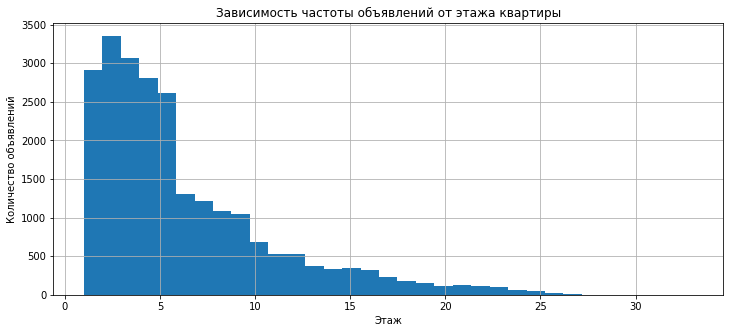

In [269]:
data['floor'].plot(kind='hist',figsize=(12,5), bins=33, grid = True)
plt.title('Зависимость частоты объявлений от этажа квартиры')
plt.xlabel('Этаж') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Минимальный этаж - 1, максимальный - 33
- Данные соответствуют распределению Пуассона
- Максимум составлюяют квартиры на 2 этаже, основное количество квартир приходится на 1-5 этаж

 ###### **type_floor** - тип этажа квартиры" (значения — «первый», «последний», «другой», «нет данных»)

In [270]:
informator(data['type_floor'])

Описание данных:
count      23650
unique         4
top       другой
freq       17324
Name: type_floor, dtype: object

Тип: <class 'str'>


In [271]:
data.pivot_table(index='type_floor', values ='floor',aggfunc='count')

,floor
type_floor,
другой,17324
нет данных,84
первый,2912
последний,3330


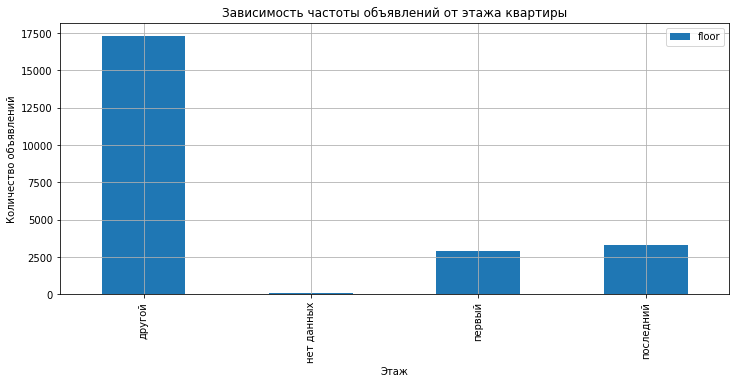

In [272]:
data.pivot_table(index='type_floor', values ='floor',aggfunc='count').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Зависимость частоты объявлений от этажа квартиры')
plt.xlabel('Этаж') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Больше всего квартир не относятся ни к первому, ни к последнему этажу
- Присутствует 84 квартиры, не относящиеся у первому этажу, у которых отсутствует информация о этажности дома

###### **floors_total** — всего этажей в доме

In [273]:
informator(data['floors_total'], False)

Описание данных:
count   23,563.00
mean        10.67
std          6.58
min          1.00
25%          5.00
50%          9.00
75%         16.00
max         37.00
Name: floors_total, dtype: float64

Тип: <class 'numpy.float64'>


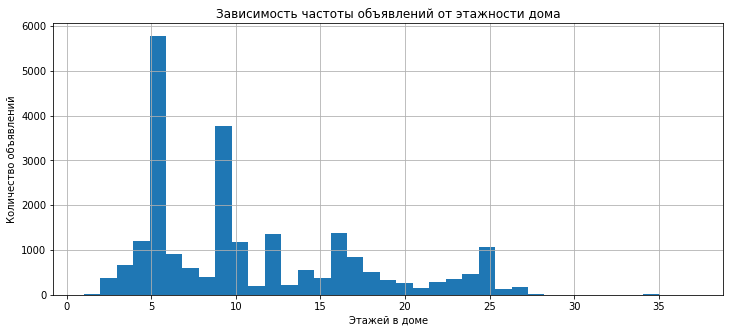

In [274]:
data['floors_total'].plot(kind='hist',figsize=(12,5), bins=37, grid = True)
plt.title('Зависимость частоты объявлений от этажности дома')
plt.xlabel('Этажей в доме') 
plt.ylabel('Количество объявлений')
plt.show()

In [275]:
data.pivot_table(index='type_floor', values='floor', aggfunc='count')

,floor
type_floor,
другой,17324
нет данных,84
первый,2912
последний,3330


**Выводы:** <br />
- Больше всего данных о квартирах, расположенных в 5-этажных домах, остальные пики относятся к 9, 16 и 25 этажным зданиям
- Присутствует 84 квартиры, у которых отсутствует информация о этажности дома

###### **cityCenters_nearest** — расстояние до центра города (м) #####

In [276]:
informator(data['cityCenters_nearest'], False)

Описание данных:
count    23,650.00
mean     24,172.71
std      30,417.54
min         181.00
25%      10,939.00
50%      14,953.50
75%      23,831.00
max     314,335.00
Name: cityCenters_nearest, dtype: float64

Тип: <class 'numpy.float64'>


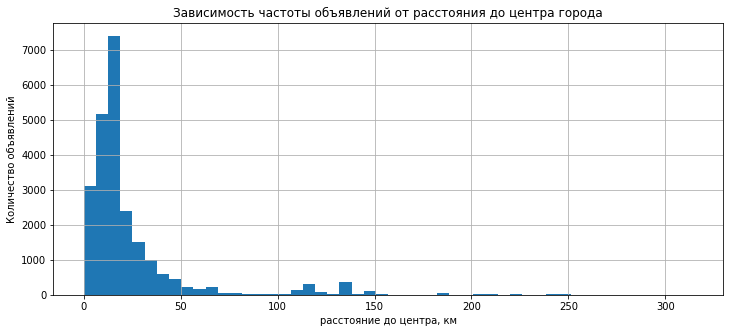

In [277]:
data['center_km'].plot(kind='hist',figsize=(12,5), bins=50, grid = True)
plt.title('Зависимость частоты объявлений от расстояния до центра города')
plt.xlabel('расстояние до центра, км') 
plt.ylabel('Количество объявлений')
plt.show()

Видно, что большая часть квартир находитсяна расстоянии до 50 км от центра, самые дальние - до 300. Как было выяснено в разделе 2, пики в районе 100-150 км относятся к крупным населенным пунктам Ленинградской области

**Выводы:** <br />
- Самый близкий объект находится в 181 м от центра города, самый дальний - в 314 км
- Данные соответствуют распределению Пуассона
- Максимум - в районе 20 км

###### **airports_nearest** — расстояние до ближайшего аэропорта в метрах (м)¶

In [278]:
informator(data['airports_nearest'], False)

Описание данных:
count    23,650.00
mean     35,803.94
std      27,644.22
min       6,060.00
25%      19,828.25
50%      30,005.50
75%      42,064.00
max     317,505.00
Name: airports_nearest, dtype: float64

Тип: <class 'numpy.float64'>


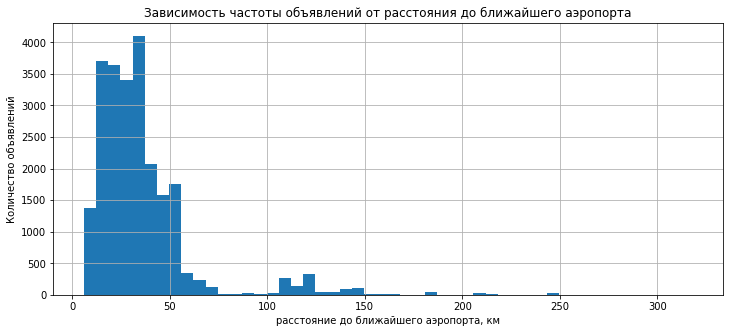

In [279]:
data['aero_km'].plot(kind='hist',figsize=(12,5), bins=50, grid = True)
plt.title('Зависимость частоты объявлений от расстояния до ближайшего аэропорта')
plt.xlabel('расстояние до ближайшего аэропорта, км') 
plt.ylabel('Количество объявлений')
plt.show()

Видно, что большая часть квартир находитсяна расстоянии до 60 км от аэропорта, самые дальние - дальше 300. Как было выяснено в разделе 2, пики в районе 100-150 км относятся к крупным населенным пунктам Ленинградской области

**Выводы:** <br />
- Самый близкий объект находится в 6 км от центра города, самый дальний - в 317 км
- Данные соответствуют распределению Пуассона
- Максимум - в районе 20 км

######  **parks_nearest** — расстояние до ближайшего парка (м)

In [280]:
informator(data['parks_nearest'], False)

Описание данных:
count   8,064.00
mean      490.83
std       342.55
min         1.00
25%       288.00
50%       454.50
75%       612.00
max     3,190.00
Name: parks_nearest, dtype: float64

Тип: <class 'numpy.float64'>


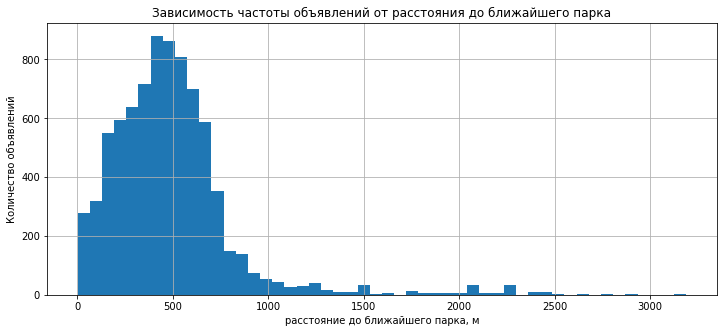

In [281]:
data['parks_nearest'].plot(kind='hist',figsize=(12,5), bins=50, grid = True)
plt.title('Зависимость частоты объявлений от расстояния до ближайшего парка')
plt.xlabel('расстояние до ближайшего парка, м') 
plt.ylabel('Количество объявлений')
plt.show()

**Выводы:** <br />
- Рядом с парками находится меньше трети квартир, из них большинство - на расстоянии до 1 км
- Самый близкий к парку объект находится на расстоянии 1 м (практически в парке), самый дальний - в 3190 м
- Данные соответствуют распределению Пуассона
- Максимум - в районе 400 км

###### **week_first_day** - день публикации объявления (0 - понедельник, 1 - вторник и т.д.)

In [282]:
data.pivot_table(index='week_first_day', values='floor', aggfunc='count')

,floor
week_first_day,
0,3606
1,4175
2,3966
3,4286
4,3992
5,1933
6,1692


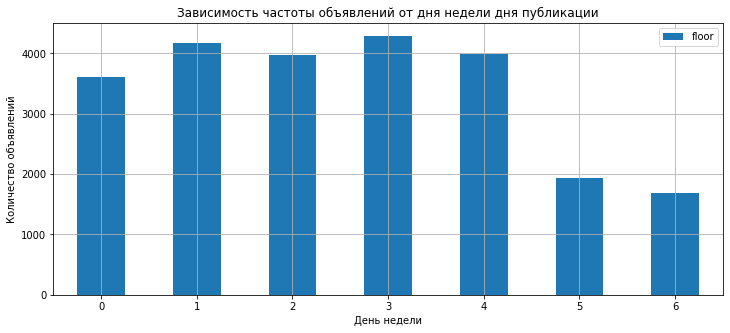

In [283]:
data.pivot_table(index='week_first_day', values='floor', aggfunc='count').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Зависимость частоты объявлений от дня недели дня публикации')
plt.xlabel('День недели') 
plt.ylabel('Количество объявлений')
plt.xticks(rotation=0)
plt.show()

**Вывод:** <br />
- Больше всего объявлений подаётся со вторника по пятницу, меньше всего - по выходным

 ###### **month_first_day** - месяц публикации объявления

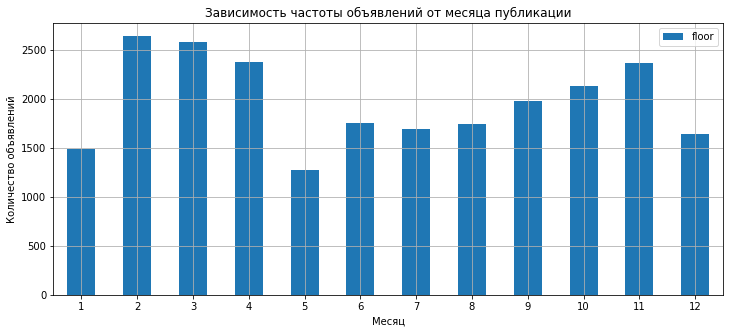

In [284]:
data.pivot_table(index='month_first_day', values='floor', aggfunc='count').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Зависимость частоты объявлений от месяца публикации')
plt.xlabel('Месяц') 
plt.ylabel('Количество объявлений')
plt.xticks(rotation=0)
plt.show()

In [285]:
data.pivot_table(index='month_first_day', values='floor', aggfunc='count')

,floor
month_first_day,
1,1491
2,2639
3,2582
4,2373
5,1270
6,1755
7,1690
8,1742
9,1979


**Вывод:** <br />
- Больше всего объявлений подаётся с февраля по апрель и с октября по ноябрь, меньше всего - в мае

###### Общий вывод по изученным параметрам объектов

Изученные данные по объектам полны, не противоречат друг другу и здравому смыслу и готовы к анализу.


#####  "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
Постройте гистограмму.
Посчитайте среднее и медиану.
В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"

###### Анализ данных:

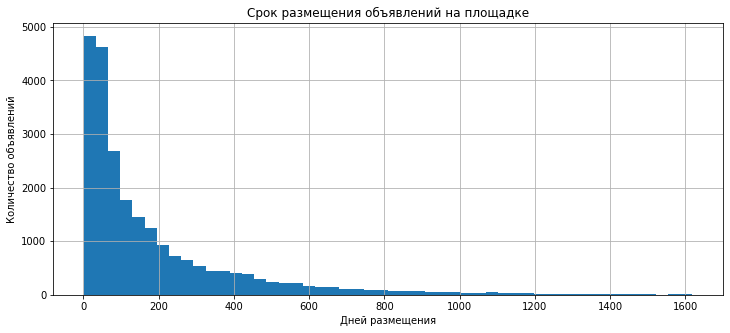

In [286]:
data['days_exposition'].plot(kind='hist',figsize=(12,5), bins=50, grid = True)
plt.title('Срок размещения объявлений на площадке')
plt.xlabel('Дней размещения') 
plt.ylabel('Количество объявлений')
plt.show()

In [287]:
data['days_exposition'].describe()

count   23,650.00
mean       185.85
std        233.47
min          1.00
25%         43.00
50%         94.00
75%        237.00
max      1,619.00
Name: days_exposition, dtype: float64

Но! У нас часть объявлений актуальна: относится к непроданным квартирам. Имеет смысл рассмотреть только квартиры, объявления по  которым закрыты

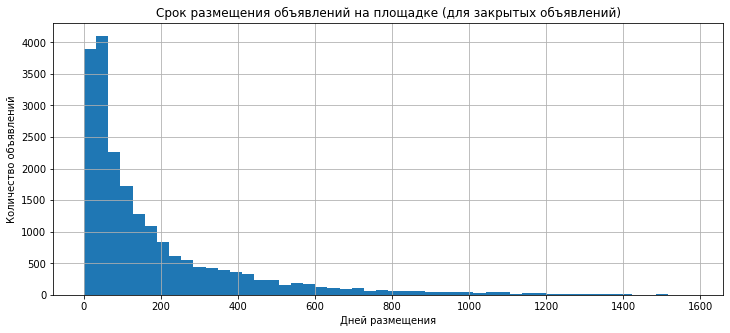

In [288]:
data[data['actual'] == False]['days_exposition'].plot(kind='hist',figsize=(12,5), bins=50, grid = True)
plt.title('Срок размещения объявлений на площадке (для закрытых объявлений)')
plt.xlabel('Дней размещения') 
plt.ylabel('Количество объявлений')
plt.show()

In [289]:
data[data['actual'] == False]['days_exposition'].describe()

count   20,470.00
mean       180.75
std        219.78
min          1.00
25%         45.00
50%         95.00
75%        231.00
max      1,580.00
Name: days_exposition, dtype: float64

Графики и описание данных очень похожи! <br />
Посмотрим долю актуальных данных:

In [290]:
len(data[data['actual']])/len(data)

0.13446088794926003

13,5% - достаточно большое число данных, но в данной конкретной задаче они не несут необходимую информацию, 
поэтому сейчас будем использовать только завершенные объявления

Рассмотрим диапазон до 100 дней:

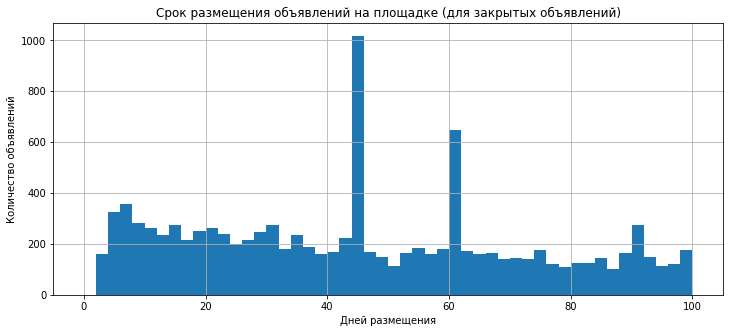

In [291]:
data[data['actual'] == False]['days_exposition'].plot(kind='hist',figsize=(12,5), bins=50, grid = True, range = [0,100])
plt.title('Срок размещения объявлений на площадке (для закрытых объявлений)')
plt.xlabel('Дней размещения') 
plt.ylabel('Количество объявлений')
plt.show()

Наблюдаются пики снятия квартир с продажи через 45 и 60 дней после размещения. 
Возможная причина - это сроки действовавших на тот момент бесплатного и льготного размещения объявлений.

###### Среднее значение и медиана

Из описания данных видно, что 
**среднее значение** времени завершенных продаж составляет **181 день** (полгода),<br />
а **медиана** этих значений - **95 дней** (чуть более 3 месяцев).

###### Какие продажи можно считать быстрыми, а какие — необычно долгими?

Построим диаграмму разброса дней продаж для завершенных объявлений

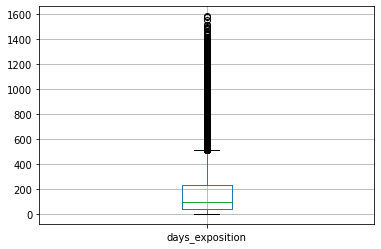

In [292]:
data[data['actual'] == False].boxplot(column='days_exposition')
plt.show()

Посмотрим поближе на интервал 0-600 дней

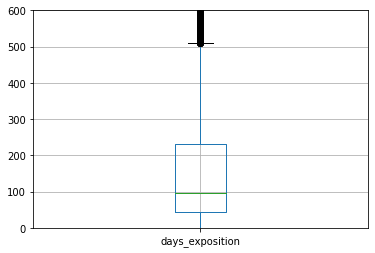

In [293]:
plt.ylim(0,600)
data[data['actual'] == False].boxplot(column='days_exposition')
plt.show()

###### Вывод:
Обычно (в половине случаев) продажа квартиры занимает - от 45 до 230 дней.<br />
Продажи, которые прошли быстрее, чем за **45 дней** можно считать **быстрыми**,<br />
продажи, которые прошли дольше, чем за **231 день** - **долгими**,<br />
а продажи, превышающие "дальний ус" диаграммы - более **500 дней**- **необычно долгими**

##### "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
  - общей площади;
  - жилой площади;
  - площади кухни;
  - количество комнат;
  - типа этажа, на котором расположена квартира (первый, последний, другой);
  - даты размещения (день недели, месяц, год);

###### Подготовка сводной таблицы

Для достоверности в сводную таблицу не включаем квартиры, по которым нет данных по этажности домов

In [294]:
dpn = data.query('type_floor != "нет данных"')[['total_area', 'living_area',  'kitchen_area', 'rooms', 'type_floor', 
                       'week_first_day', 'month_first_day', 'year_first_day', 'last_price']]

In [295]:
dpn.head()

,total_area,living_area,kitchen_area,rooms,type_floor,week_first_day,month_first_day,year_first_day,last_price
0,108.00,51.00,25.00,3,другой,3,3,2019,"13,000,000.00"
1,40.40,18.60,11.00,1,первый,1,12,2018,"3,350,000.00"
2,56.00,34.30,8.30,2,другой,3,8,2015,"5,196,000.00"
3,159.00,91.73,9.10,3,другой,4,7,2015,"64,900,000.00"
4,100.00,32.00,41.00,2,другой,1,6,2018,"10,000,000.00"


Создадим таблицу с числовыми факторами для построения матрицы диаграмм рассеивания и корелляции данных

In [296]:
dpn_num = dpn[['total_area', 'living_area',  'kitchen_area', 'rooms', 'last_price']]

###### Матрица диаграмм рассеивания и корелляция данных

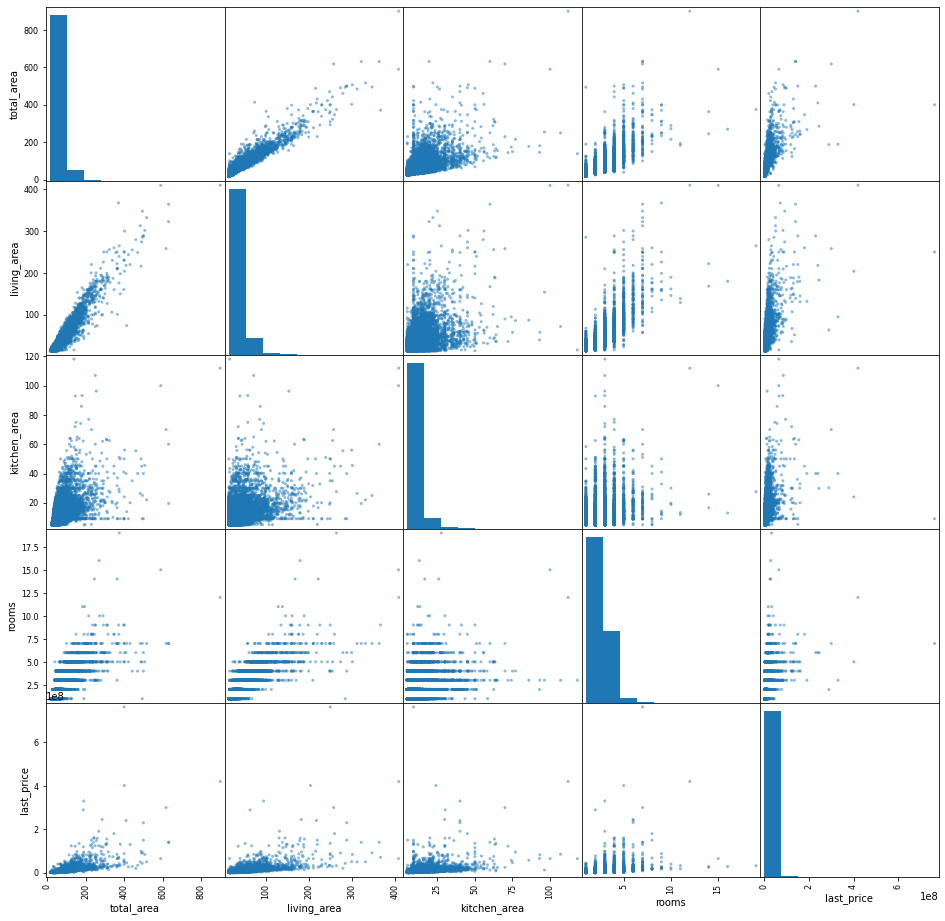

In [297]:
pd.plotting.scatter_matrix(dpn_num, figsize=(16, 16)); 

In [298]:
dpn_num.corr()

,total_area,living_area,kitchen_area,rooms,last_price
total_area,1.00,0.95,0.58,0.76,0.65
living_area,0.95,1.00,0.41,0.83,0.59
kitchen_area,0.58,0.41,1.00,0.26,0.44
rooms,0.76,0.83,0.26,1.00,0.37
last_price,0.65,0.59,0.44,0.37,1.00


На диаграммах и в таблице видна корреляция цены (в порядке убывания)
- с общей площадю квартиры;
- с жилой площадю квартиры;
- с площадью кухни;
- с количеством комнат.<br />

###### Анализ зависимости стоимости квартиры от этажа

Рассчитаем медианную цену квартир для каждого типа этажа

In [299]:
dpn.pivot_table(index='type_floor', values='last_price', aggfunc = 'median')

,last_price
type_floor,
другой,"4,850,000.00"
первый,"3,900,000.00"
последний,"4,300,000.00"


Для наглядности добавим в таблицу столбец с ценами в миллионах рублей

In [300]:
dpn['last_price_mln'] = dpn['last_price']/1000000

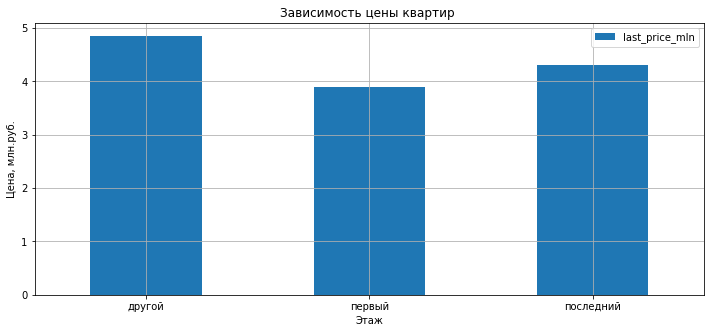

In [301]:
dpn.pivot_table(index='type_floor', values='last_price_mln', aggfunc = 'median').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Зависимость цены квартир ')
plt.xlabel('Этаж') 
plt.ylabel('Цена, млн.руб.')
plt.xticks(rotation=0)
plt.show()

Меньше всего стоят квартиры на 1 этаже, дороже всего - "не первый, не последний"

Кстати, посмотрим, сколько в среднем стоят квартиры, по которым нет информации по этажности (расположенные не на 1 этаже):

In [302]:
data.pivot_table(index='type_floor', values='last_price', aggfunc = 'median')

,last_price
type_floor,
другой,"4,850,000.00"
нет данных,"5,242,239.00"
первый,"3,900,000.00"
последний,"4,300,000.00"


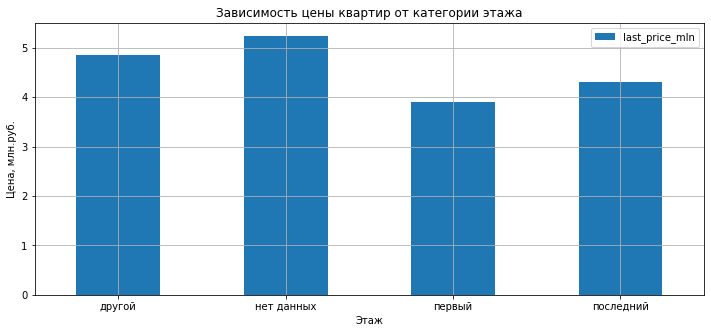

In [303]:
data.pivot_table(index='type_floor', values='last_price_mln', aggfunc = 'median').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Зависимость цены квартир от категории этажа')
plt.xlabel('Этаж') 
plt.ylabel('Цена, млн.руб.')
plt.xticks(rotation=0)
plt.show()

Похоже, этажность дома выгоднее не упоминать при продаже квартиры :)

###### Анализ зависимости стоимости квартиры от даты публикации

**Анализ зависимости стоимости квартиры от дня недели публикации**

Рассчитаем медианную цену квартир для каждого дня недели объявлений об их публикации 

In [304]:
dpn.pivot_table(index='week_first_day', values='last_price', aggfunc = 'median')

,last_price
week_first_day,
0,"4,650,000.00"
1,"4,714,595.00"
2,"4,700,000.00"
3,"4,650,000.00"
4,"4,550,000.00"
5,"4,550,000.00"
6,"4,530,000.00"


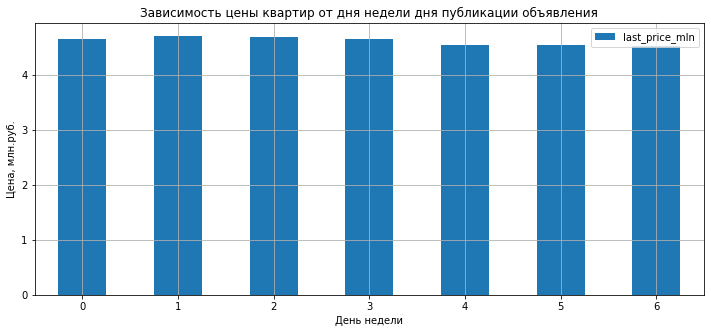

In [305]:
dpn.pivot_table(index='week_first_day', values='last_price_mln', aggfunc = 'median').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Зависимость цены квартир от дня недели дня публикации объявления')
plt.xlabel('День недели') 
plt.ylabel('Цена, млн.руб.')
plt.xticks(rotation=0)
plt.show()

Похоже, что цена от дня недели практически не зависит: разница не превышает 4%

**Анализ зависимости стоимости квартиры от месяца  публикации**

Рассчитаем медианную цену квартир для каждого месяца публикации объявлений

In [306]:
dpn.pivot_table(index='month_first_day', values='last_price', aggfunc = 'median').sort_values(by='last_price')

,last_price
month_first_day,
6,"4,400,000.00"
5,"4,500,000.00"
8,"4,565,000.00"
10,"4,570,000.00"
1,"4,600,000.00"
2,"4,650,000.00"
3,"4,650,000.00"
7,"4,650,000.00"
12,"4,695,000.00"


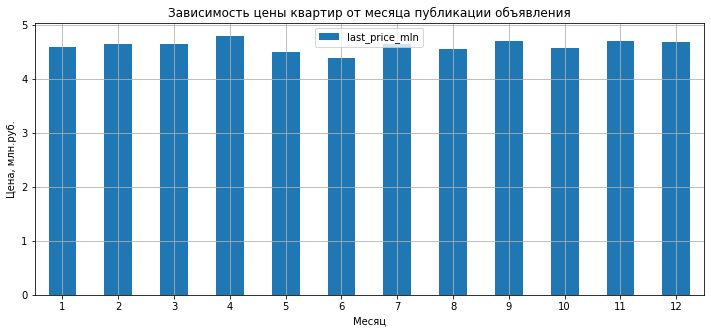

In [307]:
dpn.pivot_table(index='month_first_day', values='last_price_mln', aggfunc = 'median').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Зависимость цены квартир от месяца публикации объявления')
plt.xlabel('Месяц') 
plt.ylabel('Цена, млн.руб.')
plt.xticks(rotation=0)
plt.show()

Есть небольшая зависимость: объявления с самыми дешовыми ценами публикуют в июне, мае, августе и октябре, 
с самыми дорогими - в апреле, ноябре, сентябре и декабре. Но разница в ценах не превышает 9%

**Анализ зависимости стоимости квартиры от года  публикации**

Рассчитаем медианную цену квартир для каждого года публикации объявлений

In [308]:
dpn.pivot_table(index='year_first_day', values='last_price', aggfunc = 'median').sort_values(by='last_price')

,last_price
year_first_day,
2017,"4,500,000.00"
2016,"4,515,000.00"
2018,"4,555,000.00"
2019,"5,050,000.00"
2015,"5,300,000.00"
2014,"7,640,000.00"


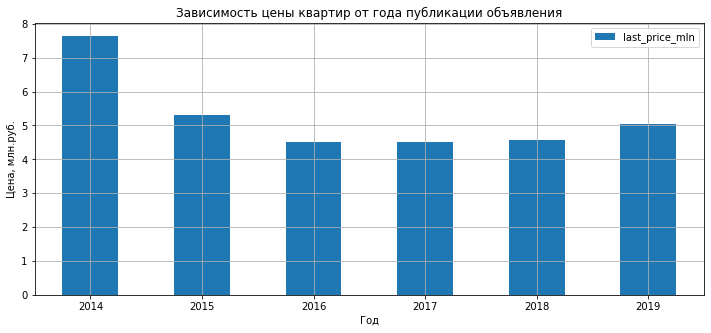

In [309]:
dpn.pivot_table(index='year_first_day', values='last_price_mln', aggfunc = 'median').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Зависимость цены квартир от года публикации объявления')
plt.xlabel('Год') 
plt.ylabel('Цена, млн.руб.')
plt.xticks(rotation=0)
plt.show()

Самые дорогие квартиры были в 2014 году. В 2015 году их цена упала более чем на 30%, в 2016-2018 - еще на 15%, а в 2019 выросла на 12%

###### Выводы:

1. Из полученных данных видно, что цена продажи зависит от (в порядке убывания важности числовых факторов):
- общей площади квартиры;
- жилой площади квартиры;
- площади кухни;
- количества комнат.<br />
2. Самые дешевые - квартиры на 1 этаже, следом идут квартиры на последнем, а "другие" - дороже их. Но самые дорогие (из тех, что выше 1 этажа) - это те, у которых не указана этажность дома.
3. День и месяц размещения на цену практически не влияют (разница цен не превышает 4 и 9 процентов соответственно)<br />
Зависимость от года публикации - существенная: самые дорогие квартиры были в 2014 году. В 2015 году их цена упала более чем на 30%, в 2016-2018 - еще на 15%, а в 2019 выросла на 12%

##### "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name."

###### Создание списка из 10 населённых пунктах с наибольшим числом объявлений

In [310]:
top_city = list(data.pivot_table(index = 'city_name', values= 'total_area', aggfunc='count') \
.sort_values(by='total_area', ascending=False).head(10).index.values)

In [311]:
top_city

['Санкт-Петербург',
 'Мурино',
 'Кудрово',
 'Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'Парголово',
 'Гатчина',
 'Выборг']

###### Фильтрация датасета по полученному списку

In [312]:
top_10 = data.query('city_name in @top_city')[['city_name','total_area','last_price', 'center_km']]

In [313]:
top_10['city_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Парголово', 'Мурино', 'Пушкин',
       'Кудрово', 'Колпино', 'Гатчина', 'Выборг', 'Всеволожск'],
      dtype=object)

###### Подсчёт средней цены одного квадратного метра

Цена квадратного метра:

In [314]:
top_10['m_price'] = top_10['last_price']/top_10['total_area']

Средние значения:

In [315]:
mean_meter = top_10.pivot_table(index='city_name', values='m_price', aggfunc='mean').sort_values(by='m_price', ascending=False)
mean_meter

,m_price
city_name,
Санкт-Петербург,"114,951.18"
Пушкин,"103,052.30"
Кудрово,"96,230.36"
Парголово,"90,566.80"
Мурино,"86,635.79"
Шушары,"78,720.02"
Колпино,"75,438.42"
Гатчина,"68,746.15"
Всеволожск,"68,714.44"


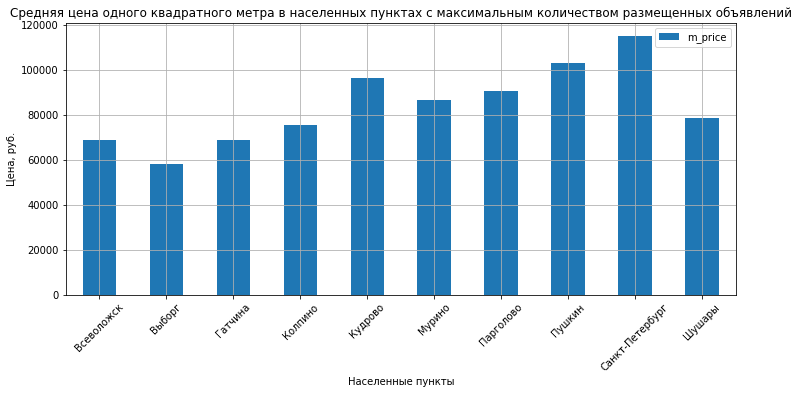

In [316]:
top_10.pivot_table(index='city_name', values='m_price', aggfunc='mean').plot(kind='bar',figsize=(12,5), grid = True)
plt.title('Средняя цена одного квадратного метра в населенных пунктах с максимальным количеством размещенных объявлений')
plt.xlabel('Населенные пункты') 
plt.ylabel('Цена, руб.')
plt.xticks(rotation=45)
plt.show()

###### Вывод:

Из 10 населенных пунктов Ленинградской области с самым большим количеством опубликованных объявлений:
- максимальная средняя стоимость квадратного метра  - в Санкт-Петербурге: 114 951 рубль 18 коп.
- минимальная средняя стоимость квадратного метра  - в Выборге: 58 017 рублей 62 коп.

##### "Выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."

Из условия задания не понятно, имеется в виду средняя цена квартир или квадратного метра. Будем решать обе задачи.

###### Из созданной в прошлой задаче таблицы создадим таблицу для Санкт-Петербурга

In [317]:
spb = top_10.query('city_name == "Санкт-Петербург"')

In [318]:
spb.head()

,city_name,total_area,last_price,center_km,m_price
0,Санкт-Петербург,108.00,"13,000,000.00",16,"120,370.37"
2,Санкт-Петербург,56.00,"5,196,000.00",14,"92,785.71"
3,Санкт-Петербург,159.00,"64,900,000.00",7,"408,176.10"
4,Санкт-Петербург,100.00,"10,000,000.00",8,"100,000.00"
7,Санкт-Петербург,71.60,"7,915,000.00",12,"110,544.69"


###### Средняя цена квадратного метра в зависимости от расстояния от центра Санкт-Петербурга:

In [319]:
center_km_meter = spb.pivot_table(index='center_km', values = 'm_price', aggfunc='mean')
center_km_meter.head(20)

,m_price
center_km,
0,"245,833.53"
1,"175,598.71"
2,"157,664.23"
3,"121,386.35"
4,"133,194.93"
5,"140,449.90"
6,"151,323.14"
7,"156,155.72"
8,"126,013.18"


Построим график для их значений

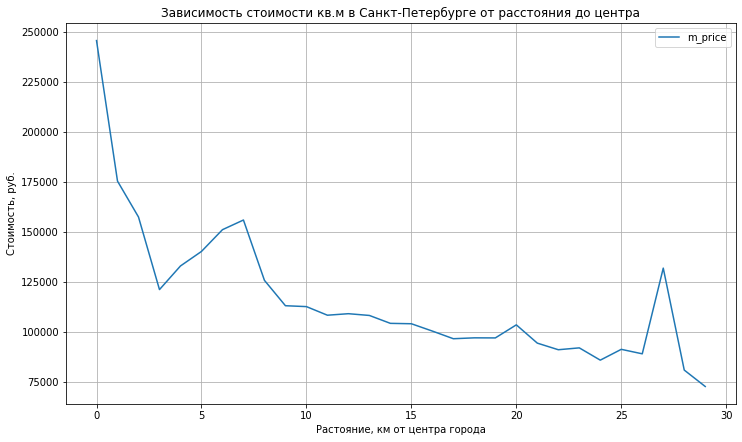

In [320]:
center_km_meter.plot(title='Зависимость стоимости кв.м в Санкт-Петербурге от расстояния до центра', 
                     grid=True, figsize=(12,7), ylabel ='Стоимость, руб.', xlabel='Растояние, км от центра города');

**Вывод:** 
Стоимость квадратного метра падает с расстоянием от центра, 
    однако на у квартир на расстоянии 6-7 и 27 км эта стоимость резко возрастает. Возможно на этом расстоянии находятся районы с более престижным жильём.

###### Средняя цена квартиры в зависимости от расстояния от центра Санкт-Петербурга:

In [321]:
center_km_flat = spb.pivot_table(index='center_km', values = 'last_price', aggfunc='mean')
center_km_flat.head(20)

,last_price
center_km,
0,"31,449,115.85"
1,"21,206,720.83"
2,"17,788,319.61"
3,"11,126,581.00"
4,"13,311,361.98"
5,"14,491,259.63"
6,"15,338,418.39"
7,"14,775,152.59"
8,"9,957,716.83"


Построим график для их значений

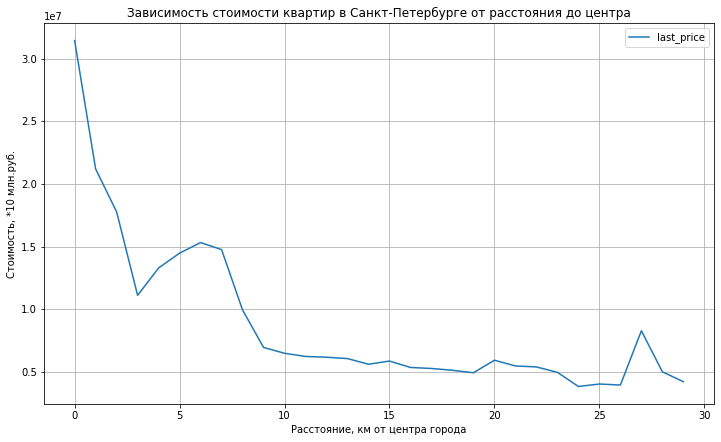

In [322]:
center_km_flat.plot(title='Зависимость стоимости квартир в Санкт-Петербурге от расстояния до центра', 
                     grid=True, figsize=(12,7), ylabel ='Стоимость, *10 млн.руб.', xlabel='Расстояние, км от центра города');

**Вывод:** 
Стоимость квартир падает с расстоянием от центра, 
    однако у квартир на расстоянии 6-7 и 27 км эта стоимость резко возрастает. Возможно на этом расстоянии находятся районы с более престижным жильём.

###### Вывод по задаче

Стоимость километра (как для квартир в целом, так и для 1 кв.м) падает с расстоянием от центра, однако на расстоянии 6-7 и 27 км эта стоимость резко возрастает. Возможно на этом расстоянии находятся районы с более престижным жильём.

#### Общий вывод по этапу 4:

Решены задачи исследовательского анализа данных:
1 . Изученные данные по объектам полны, не противоречат друг другу и здравому смыслу и готовы к анализу.    
2 Обычно (в половине случаев) продажа квартиры занимает - от 45 до 230 дней.
Продажи, которые прошли быстрее, чем за 45 дней можно считать быстрыми,
продажи, которые прошли дольше, чем за 231 день - долгими,
а продажи, превышающие 500 дней- необычно долгими <br />
3. Цена продажи зависит от (в порядке убывания важности числовых факторов):
- общей площади квартиры;
- жилой площади квартиры;
- площади кухни;
 - количества комнат. <br />
4. День и месяц размещения на цену практически не влияют (разница цен не превышает 4 и 9 процентов соответственно).<br />
Зависимость от года публикации - существенная: самые дорогие квартиры были в 2014 году. В 2015 году их цена упала более чем на 30%, в 2016-2018 - еще на 15%, а в 2019 выросла на 12% <br />
5. Самые дешевые - квартиры на 1 этаже, следом идут квартиры на последнем, а "другие" - дороже их. Но самые дорогие (из тех, что выше 1 этажа) - это те, у которых не указана этажность дома.
6. Из 10 населенных пунктов Ленинградской области с самым большим количеством опубликованных объявлений:
- максимальная средняя стоимость квадратного метра - в Санкт-Петербурге: 114 951 рубль 18 коп.
- минимальная средняя стоимость квадратного метра - в Выборге: 58 017 рублей 62 коп. <br />
7. Стоимость километра (как для квартир в целом, так и для 1 кв.м) падает с расстоянием от центра, однако на расстоянии 6-7 и 27 км эта стоимость резко возрастает. Возможно на этом расстоянии находятся районы с более престижным жильём.


### Общий вывод

**I. Исходные данные**
1. Анализ проводился на основе выгрузки данных сервиса Яндекс Недвижимость за период с 27.11.2014 по 03.05.2019. 
2. В предоставленных данных находится информация о 23699 квартирах в Санкт-Петербурге и Ленинградской области.
3. Состояние данных - неудовлетварительное, отсутствуют даже те данные, которые Яндекс.Недвижимость должна была добавлять автоматически. 
**II. Предобработка данных**
1. В связи с тем, что планировался многофакторный анализ, удаление данных, содержащих некорректную или отсутствующую информацию, было признано нежелательным
2. Для востановления пространственных данных использовались данные, подготовленные в ГИС ArcGIS 
3. Также для восстановления данных использовались математические методы, рассчёты на основе других параметров, СНИПы и НПА г.Санкт-Петербург, а также логика и жизненный опыт.
4. В результате предобработки удалось сохранить данные об 23650 из 23699 квартир
5. Для удобства обработки и анализа объектам были добавлены дополнительные атрибуты.
6. Данные подготовлены к проведению исследовательского анализа<br />
**III. Исследовательский анализ**
1. На анализ были представлены следующие задачи:
- Изучить параметры объектов
- Изучить, как быстро продавались квартиры
- Выяснить, какие факторы больше всего влияют на общую (полную) стоимость объекта?
- Расчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. 
- Описать, как стоимость объектов зависит от расстояния до центра города.
2. *Изучить параметры объектов*<br />
Изученные данные объектов после проведенной предобработки полны, не противоречат друг другу и здравому смыслу и готовы к анализу.    
3. *Изучить, как быстро продавались квартиры*<br />
В половине случаев продажа квартиры занимает - от 45 до 230 дней.
Продажи, которые прошли быстрее, чем за 45 дней можно считать быстрыми,
продажи, которые прошли дольше, чем за 231 день - долгими,
а продажи, превышающие 500 дней- необычно долгими <br />
4. *Выяснить, какие факторы (из заданных) больше всего влияют на общую (полную) стоимость объекта?*<br />
    4.1. Цена продажи зависит от (в порядке убывания важности числовых факторов):<br />
    - общей площади квартиры;
    - жилой площади квартиры;
    - площади кухни;
    - количества комнат.
    4.2. Самые дешевые - квартиры на 1 этаже, следом идут квартиры на последнем, а "другие" - дороже их. Но самые дорогие (из тех, что выше 1 этажа) - это те, у которых не указана этажность дома.<br />
    4.3. День и месяц размещения на цену практически не влияют (разница цен не превышает 4 и 9 процентов соответственно).<br />
    4.4. Зависимость от года публикации - существенная: самые дорогие квартиры были в 2014 году. В 2015 году их цена упала более чем на 30%, в 2016-2018 - еще на 15%, а в 2019 выросла на 12%.<br />
5. *Расчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра.*<br />
Из 10 населенных пунктов Ленинградской области с самым большим количеством опубликованных объявлений:
- максимальная средняя стоимость квадратного метра - в Санкт-Петербурге: 114 951 рубль 18 коп.
- минимальная средняя стоимость квадратного метра - в Выборге: 58 017 рублей 62 коп. <br />
6. *Описать, как стоимость объектов зависит от расстояния до центра города.*<br />
Стоимость километра (как для квартир в целом, так и для 1 кв.м) падает с расстоянием от центра, однако на расстоянии 6-7 и 27 км эта стоимость резко возрастает. Возможно на этом расстоянии находятся районы с более престижным жильём.
**IV. Итог**<br />
Все поставленные задачи по проекту выполнены.